## Topographic Heterogeneity and Aspect Moderate Exposure to Climate Change Across an Alpine Tundra Hillslope
##### This notebook accesses data from the Community Land Model as well as observational datasets from Niwot Ridge LTER (available on EDI) and plots results from simulations with hillslope hydrology as described in the manuscript 'Topographic Heterogeneity and Aspect Moderate Exposure to Climate Change Across an Alpine Tundra Hillslope'

### Load packages

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
from scipy import signal,stats
import cftime
import nc_time_axis
import dask
import functools
#import cf_units as cf

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.dates as mdates

import matplotlib.colors as mcolors
from matplotlib.pyplot import cm

# suppress Runtime warnings that let you know when code isn't running too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
from distributed import wait

%matplotlib inline

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='2:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient(nmem='2GB')
cluster.scale(5)

/glade/work/jayka/opt/miniconda/envs/ctsm-py/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40955 instead
  f"Port {expected} is already in use.\n"


In [4]:
cluster

### Read in CLM model output

#### First point to files

In [47]:
# Niwot LTER  simulations
# H1 files dimensioned time x column or time x pft
path = '/glade/scratch/jayka/archive/' # path to files
cases = ['NEON_NIWO_saddle_hh2_slope0.3_soilmod_jmaxb0_trans','NEON_NIWO_south_hh2_slope0.3_soilmod_jmaxb0_trans','NEON_NIWO_north_hh2_slope0.3_soilmod_jmaxb0_trans','NEON_NIWO_saddle_hh2_slope0.3_soilmod_jmaxb0_anom',
        'NEON_NIWO_south_hh2_slope0.3_soilmod_jmaxb0_anom','NEON_NIWO_north_hh2_slope0.3_soilmod_jmaxb0_anom'] # case names
rollHour = -12  
years = range(2008,2022)
years2 = range(2087,2101)
nmon = 12

out_dir = '/glade/u/home/jayka/NWT_CLM_plots/figures/'

# create a list of the files we'll open for each case
finSaddle = [path + cases[0] +'/lnd/hist/'+cases[0]+'.clm2.h1.'+str(years[i]) +'-01-01-00000.nc' \
           for i in range(len(years)) ]
finSouth = [path + cases[1] +'/lnd/hist/'+cases[1]+'.clm2.h1.'+str(years[i]) +'-01-01-00000.nc' \
           for i in range(len(years)) ]
finNorth = [path + cases[2] +'/lnd/hist/'+cases[2]+'.clm2.h1.'+str(years[i]) +'-01-01-00000.nc' \
           for i in range(len(years)) ]
finSadAnom = [path + cases[3] +'/lnd/hist/'+cases[3]+'.clm2.h1.'+str(years2[i]) +'-01-01-00000.nc' \
           for i in range(len(years2)) ]
finSouthAnom = [path + cases[4] +'/lnd/hist/'+cases[4]+'.clm2.h1.'+str(years2[i]) +'-01-01-00000.nc' \
           for i in range(len(years2)) ]
finNorthAnom = [path + cases[5] +'/lnd/hist/'+cases[5]+'.clm2.h1.'+str(years2[i]) +'-01-01-00000.nc' \
           for i in range(len(years2)) ]

# print the last year of data loaded
print(finSaddle[-1])
print(finSouth[-1])
print(finNorth[-1])
print(finSadAnom[-1])

/glade/scratch/jayka/archive/NEON_NIWO_saddle_hh2_slope0.3_soilmod_jmaxb0_trans/lnd/hist/NEON_NIWO_saddle_hh2_slope0.3_soilmod_jmaxb0_trans.clm2.h1.2021-01-01-00000.nc
/glade/scratch/jayka/archive/NEON_NIWO_south_hh2_slope0.3_soilmod_jmaxb0_trans/lnd/hist/NEON_NIWO_south_hh2_slope0.3_soilmod_jmaxb0_trans.clm2.h1.2021-01-01-00000.nc
/glade/scratch/jayka/archive/NEON_NIWO_north_hh2_slope0.3_soilmod_jmaxb0_trans/lnd/hist/NEON_NIWO_north_hh2_slope0.3_soilmod_jmaxb0_trans.clm2.h1.2021-01-01-00000.nc
/glade/scratch/jayka/archive/NEON_NIWO_saddle_hh2_slope0.3_soilmod_jmaxb0_anom/lnd/hist/NEON_NIWO_saddle_hh2_slope0.3_soilmod_jmaxb0_anom.clm2.h1.2100-01-01-00000.nc


In [48]:
# combine transient and forced cases (2008-2100)
fileSaddle = finSaddle + finSadAnom
fileSouth = finSouth + finSouthAnom
fileNorth = finNorth + finNorthAnom

#### Read in data with preprocessing

In [49]:
# define the history variables to read in
fields = ['AGNPP','AR','BTRANMN','ELAI', 'FCEV','FCTR','FGEV','FIRA','FSA','FSR','FSH','FSDS','GPP','H2OSOI','RAIN','SNOW','SNOW_DEPTH','TBOT','TSOI','QLATFLOWOUT','GR','MR','NPP_NUPTAKE','pft','TV','TOTECOSYSC','QOVER','QDRAI_PERCH','QRUNOFF'] #

def preprocess(ds, fields):
    '''Selects the variables we want to read in'''
    
    return ds[fields]

# open the datasets -- two for each case
# 2008-2021
dsSad1 = xr.open_mfdataset(finSaddle, decode_times=True, 
                                 preprocess=functools.partial(preprocess, fields=fields))

dsSouth1 = xr.open_mfdataset(finSouth, decode_times=True,
                                preprocess=functools.partial(preprocess, fields=fields))

dsNorth1 = xr.open_mfdataset(finNorth, decode_times=True,
                                 preprocess=functools.partial(preprocess, fields=fields))

# 2087-2100
dsSad2 = xr.open_mfdataset(finSadAnom, decode_times=True, 
                                 preprocess=functools.partial(preprocess, fields=fields))
dsSouth2 = xr.open_mfdataset(finSouthAnom, decode_times=True,
                                preprocess=functools.partial(preprocess, fields=fields))
dsNorth2 = xr.open_mfdataset(finNorthAnom, decode_times=True,
                                 preprocess=functools.partial(preprocess, fields=fields))


print('-- your data have been read in -- ')

-- your data have been read in -- 


In [50]:
# Combine pft and column coordinates
dsSad1 = dsSad1.rename({'pft':'column'})
dsSouth1 = dsSouth1.rename({'pft':'column'})
dsNorth1 = dsNorth1.rename({'pft':'column'})
dsSad2 = dsSad2.rename({'pft':'column'})
dsSouth2 = dsSouth2.rename({'pft':'column'})
dsNorth2 = dsNorth2.rename({'pft':'column'})

In [51]:
# Rename columns
dsSad1 = dsSad1.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})
dsSouth1 = dsSouth1.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})
dsNorth1 = dsNorth1.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})
dsSad2 = dsSad2.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})
dsSouth2 = dsSouth2.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})
dsNorth2 = dsNorth2.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})

In [52]:
# Combine all CLM datasets for the control (2008-2021) using 'sim' dimension to allow sorting and plotting by case
ds1 = xr.concat([dsSad1,dsSouth1,dsNorth1], 'sim', data_vars='all')
ds1 = ds1.assign_coords(sim=("sim", ['Saddle','South','North']))
# Combine all CLM datasets for the future time series (2087-2100) using 'sim' dimension to allow sorting and plotting by case
ds2 = xr.concat([dsSad2,dsSouth2,dsNorth2], 'sim', data_vars='all')
ds2 = ds2.assign_coords(sim=("sim", ['Saddle','South','North']))

In [53]:
# Make aspect datasets without Saddle case for plotting N and S results
ds1Aspect = xr.concat([dsSouth1,dsNorth1], 'sim', data_vars='all')
ds1Aspect = ds1Aspect.assign_coords(sim=("sim", ['South','North']))
ds2Aspect = xr.concat([dsSouth2,dsNorth2], 'sim', data_vars='all')
ds2Aspect = ds2Aspect.assign_coords(sim=("sim", ['South','North']))

In [54]:
# define control and future datasets for change analysis
# select years 2092-99 from 2087-2100 dataset and 2008-2015 from 2008-2021 dataset because 2099 corresponds with 2015 input data
ftime = [0,87600]
ltime = [140160,227760]

In [55]:
# select time periods
ds1_2015 = ds1Aspect.isel(time=slice(ftime[0], ltime[0]))
ds2_2100 = ds2Aspect.isel(time=slice(ftime[1], ltime[1]))
#ds2_2015.time
#ds2_2100.time

### Read in observations from the Saddle/Sensor network array to compare with CLM simulations (snow, soils, NPP, GCC)


In [27]:
nwtOBS = '/glade/work/jayka/inputdata/NWT_obs/'
dsNET = pd.read_table(nwtOBS+'sensor_network_soil_data_30_min.txt')#.to_xarray()  # Saddle sensors
dsTVan = pd.read_table(nwtOBS+'tvan_soil_data_30_min.txt') # Tvan soil sensors
dsSNO = pd.read_table(nwtOBS+'saddle_grid_snow_depth_data_biweekly.txt') # Saddle snow 
dsNPP = pd.read_table(nwtOBS+'saddle_grid_productivity_data.txt')    # Saddle productivity
dsPHN = pd.read_table(nwtOBS+'saddle_sensntwk_phenocam_filtered.txt') # Saddle phenocam data
#dsSNO_sens = pd.read_table(nwtOBS+'sensor_network_snow_data_30_min.txt') # sn array snow 

# add date-time
dsNET.date = pd.to_datetime(dsNET.date)
dsTVan.date = pd.to_datetime(dsTVan.date)
dsSNO.date = pd.to_datetime(dsSNO.date)
#dsSNO_sens.date = pd.to_datetime(dsSNO_sens.date)
dsPHN.date = pd.to_datetime(dsPHN.date)
#dsNPP.date = pd.to_datetime(dsNPP.date)

# combine sensor data from saddle network and Tvan
dsSOI = pd.concat([dsNET,dsTVan]) 

/glade/work/jayka/opt/miniconda/envs/ctsm-py/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [28]:
# Aggregate data by date & vegetation community 
dsSOIgroup = dsSOI.groupby(['date','veg_com'])
dsSOIdaily = dsSOIgroup.aggregate(np.mean)
dsSOIdailySTD = dsSOIgroup.aggregate(np.std)

# This is already done for snowdepth, but now we'll get results dimensioned by date*veg_com
#dsSNOgroup_sens = dsSNO_sens.groupby(['date','veg_com'])
#dsSNOdaily_sens = dsSNOgroup_sens.aggregate(np.mean)

dsSNOgroup = dsSNO.groupby(['date','veg_com'])
dsSNOdaily = dsSNOgroup.aggregate(np.mean)

dsNPPgroup = dsNPP.groupby(['year','veg_com'])
dsNPPdaily = dsNPPgroup.aggregate(np.mean)
dsNPPdailySTD = dsNPPgroup.aggregate(np.std)

dsPHNgroup = dsPHN.groupby(['date','veg_com'])
dsPHNdaily = dsPHNgroup.aggregate(np.mean)

In [29]:
# Convert Saddle and Sensor Network data to xarray
dsSOI = dsSOIdaily.to_xarray()
dsSOIstd = dsSOIdailySTD.to_xarray()
dsSNO = dsSNOdaily.to_xarray()
#dsSNO_sens = dsSNOdaily_sens.to_xarray()
dsNPP = dsNPPdaily.to_xarray()
dsNPPstd = dsNPPdailySTD.to_xarray()
dsPHN = dsPHNdaily.to_xarray()

# reindex by veg community for plotting consistency
#Veg = ["DM", "MM","WM"]
Veg = ["WM","DM", "MM"]
fullVeg = ["wet_meadow","dry_meadow", "moist_meadow"]
dsSOI = dsSOI.reindex({'veg_com': Veg})
dsSOIstd = dsSOIstd.reindex({'veg_com': Veg})
dsSNO = dsSNO.reindex({'veg_com': Veg})
#dsSNO_sens = dsSNO_sens.reindex({'veg_com': Veg})
dsNPP = dsNPP.reindex({'veg_com': Veg})
dsNPPstd = dsNPPstd.reindex({'veg_com': Veg})

# reindex CLM dataset by veg community
veg  = ["wm","dm","mm"]
ds1 = ds1.reindex({'column': veg})

In [30]:
# Run this instead of the above cell if wanting to index in the order mm, wm, dm for plots
# Convert Saddle and Sensor Network data to xarray
dsSOI = dsSOIdaily.to_xarray()
dsSOIstd = dsSOIdailySTD.to_xarray()
dsSNO = dsSNOdaily.to_xarray()
#dsSNO_sens = dsSNOdaily_sens.to_xarray()
dsNPP = dsNPPdaily.to_xarray()
dsNPPstd = dsNPPdailySTD.to_xarray()
dsPHN = dsPHNdaily.to_xarray()

# reindex by veg community for plotting consistency
#Veg = ["DM", "MM","WM"]
Veg = ["MM","WM", "DM"]
fullVeg = ["moist_meadow","wet_meadow", "dry_meadow"]
dsSOI = dsSOI.reindex({'veg_com': Veg})
dsSOIstd = dsSOIstd.reindex({'veg_com': Veg})
dsSNO = dsSNO.reindex({'veg_com': Veg})
#dsSNO_sens = dsSNO_sens.reindex({'veg_com': Veg})
dsNPP = dsNPP.reindex({'veg_com': Veg})
dsNPPstd = dsNPPstd.reindex({'veg_com': Veg})

# reindex CLM dataset by veg community
veg  = ["mm","wm","dm"]
ds1 = ds1.reindex({'column': veg})
#ds2 = ds2.reindex({'column': veg})

### Read in T-Van flux tower observations to compare with simulations (GPP)

In [19]:
longSite  =  'dry_meadow'
years = range(2008,2022)
nmon  = 12
OBSdir = '/glade/work/jayka/inputdata/datm_NWT_Tvan/'+longSite+'/'
OBSfile = [OBSdir + str(years[i])+'-'+str(m+1).zfill(2)+'.nc' for i in range(len(years))  for m in range(nmon)]  
dsOBS = utils.time_set_mid(xr.open_mfdataset(OBSfile, decode_times=True, combine='by_coords'), 'time')

In [20]:
# Now remove extra dimensions & coordinates
dsOBS  = dsOBS.isel(lat=0, lon=0)

# Remove CLM time shift
#ds1 = ds1.isel(lndgrid=0)
ds1 = ds1.shift(time=-1)

In [21]:
# Convert observed GPP units from umol/m2/s to g/m2/d
# Assumes NEON results are umolC (not CO2) m^-2 s^-1
dsOBS['GPP'] = dsOBS.GPP * 1e-6 * 12.01 * 3600 * 24
dsOBS['GPP'].attrs['units'] = 'gC/m2/d'

# Now convert CLM GPP units from g/m2/s to g/m2/d
ds1['GPP'] = ds1.GPP * 3600 * 24
ds1['GPP'].attrs['units'] = 'gC/m2/d'

In [27]:
# calculate daily means, mask out non-growing season & calculate rolling mean
# no GPP before May 15 & growing season ends Sept 30 (DOY = 135, 273)

temp = dsOBS['GPP'].resample(time='D').mean()   #daily fluxes
temp = temp.where(temp['time.dayofyear']>135,0)  
temp = temp.where(temp['time.dayofyear']<273,0).chunk({'time':100}) 
# set GPP<0 to zero
temp = temp.where(temp>0,0)
#temp = temp.rolling(time=10, center=True).mean()#.dropna("time") # rolling mean

### Model evaluation figures

#### Climatologies of Niwot observations and model output (Figure 2)
Saddle snow depth (2008-2021) and Sensor Network soil moisture and temperature (2018-2021) time series

In [15]:
# strings for labeling panels
panel = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)'] 
panel2 = ['(d)','(e)','(f)','(g)','(h)','(i)'] 
panel3 = ['(g)','(h)','(i)'] 

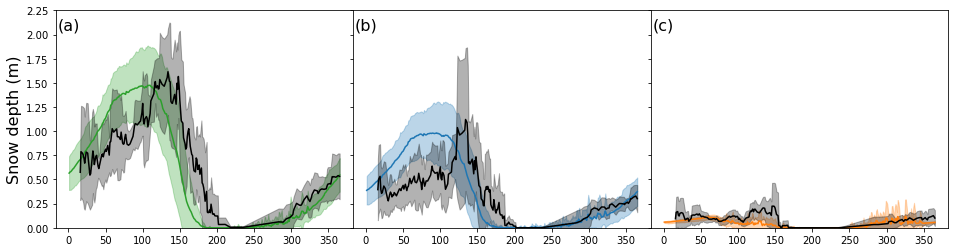

In [24]:
colorlist = ['tab:green','tab:blue','tab:orange']

x_obs = (dsSNO.avg_date_depth/100).groupby("date.dayofyear").mean('date')
y_clm = ds1.SNOW_DEPTH.sel(sim='Saddle').groupby("time.dayofyear").mean('time')
y_clmSD = ds1.SNOW_DEPTH.sel(sim='Saddle').groupby("time.dayofyear").std('time')

x_obs_rolling = x_obs.rolling(dayofyear=7).mean()
x_obs_rolling_std = x_obs.rolling(dayofyear=7).std()

fig, axs = plt.subplots(1, 3, sharey=True, gridspec_kw={'wspace': 0, 'hspace': 0}, figsize=(16,4))

for i in range(len(ds1.column)):
        
    y1 = y_clm.isel(column=i)
    y2 = x_obs_rolling.isel(veg_com=i)
    y1SD = y_clmSD.isel(column=i)
    y2SD = x_obs_rolling_std.isel(veg_com=i)

    axs[i].plot(y_clm['dayofyear'], y1, label="CLM5", color=colorlist[i]) ;
    axs[i].plot(x_obs_rolling['dayofyear'], y2, label="Obs", color='k') ;
    axs[i].fill_between(y1['dayofyear'], y1 - y1SD, y1 + y1SD, alpha=0.3, color=colorlist[i])
    axs[i].fill_between(y2['dayofyear'], y2 - y2SD, y2 + y2SD, alpha=0.3, color="k")
    
    axs[i].set_ylim([0,2.25])
    #axs[i].legend(('CLM5','Obs'), frameon=False, fontsize='large', loc='upper right')
    
    axs[i].annotate(panel[i], xy=(0.05, 2.1), 
                ha='center', va='center',fontsize=16)  
    
    if i == 0:
        axs[i].set_ylabel('Snow depth (m)', fontsize=16)
        
    #if i == 1:
     #   axs[i].set_xlabel('Day of year', fontsize=16)

#fig.tight_layout()
plt.savefig(out_dir+'Fig2a-c.pdf');

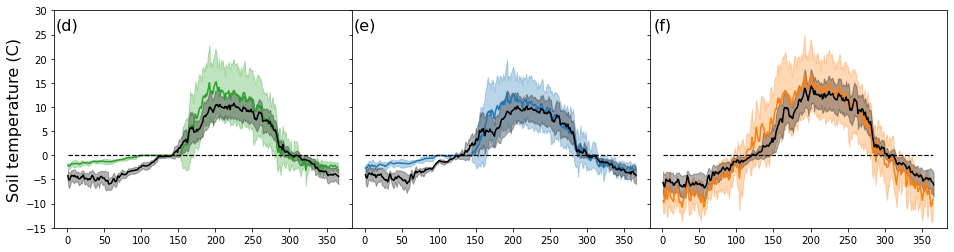

In [25]:
#TSOI_Sad = ds2.TSOI.sel(sim='Saddle').isel(levgrnd=1).where(ds1.sel(sim='Saddle').ELAI>0)
colorlist = ['tab:green','tab:blue','tab:orange']

x = ((ds1.TSOI.sel(sim='Saddle').isel(levgrnd=1))-273.15).where(ds1.TSOI['time.year']>2016)
x1 = x.groupby("time.dayofyear").mean('time')
x2 = dsSOI.soiltemp_upper_avg.groupby("date.dayofyear").mean('date')
x1SD = x.groupby("time.dayofyear").std('time')
x2SD = dsSOIstd.soiltemp_upper_avg.groupby("date.dayofyear").mean('date')

fig, axs = plt.subplots(1, 3,  gridspec_kw={'wspace': 0, 'hspace': 0}, figsize=(16,4))

for i in range(len(ds1.column)):
    
    y1 =  x1.isel(column=i)
    y2 = x2.isel(veg_com=i)
    y1SD = x1SD.isel(column=i)
    y2SD = x2SD.isel(veg_com=i)

    axs[i].plot(x1['dayofyear'], y1, label="CLM5", color=colorlist[i]) ;
    axs[i].plot(x2['dayofyear'], y2, label="CLM5", color='k') ;
    axs[i].fill_between(x1['dayofyear'], y1 - y1SD, y1 + y1SD, alpha=0.3, color=colorlist[i])
    axs[i].fill_between(x2['dayofyear'], y2 - y2SD, y2 + y2SD, alpha=0.3, color="k")
    axs[i].plot(x1['dayofyear'], np.zeros(365), '--', linewidth=1.2, color='k')
   # axs[i].legend(('CLM5','Obs'), frameon=False,fontsize='large')
    
    axs[i].set_ylim([-15, 30])
     
    axs[i].annotate(panel2[i], xy=(0.05, 27), 
                ha='center', va='center',fontsize=16)  
    
    if i==0:
        axs[i].set_ylabel('Soil temperature (C)', fontsize=16) 
    else:
        axs[i].axes.yaxis.set_ticklabels([]) 
        
  #  if i == 1:
  #      axs[i].set_xlabel('Day of year', fontsize=16)
    
#fig.tight_layout()
plt.savefig(out_dir+'Fig2d-f.pdf');

##### SD info for soils plots: Data were aggregated by date and veg com (thus grouping across 30 min time stamps for each day and sensors for each community), then a mean and SD was calculated for each date and community.
##### To create the plots, those mean and SD values were averaged by DOY across the whole time series

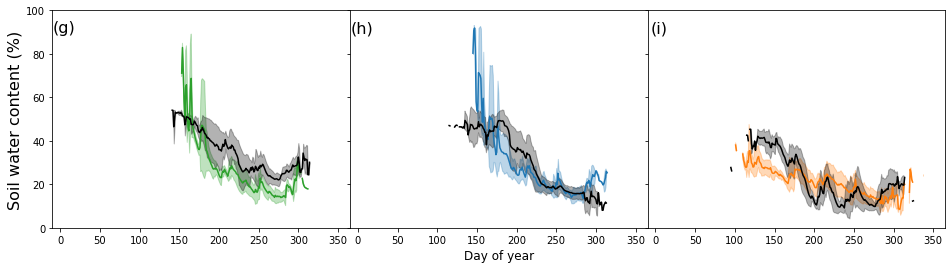

In [26]:
# Plot obs vs CLM soil moisture, aggregated by doy from 2017-2021
colorlist = ['tab:green','tab:blue','tab:orange']

# mask soil temp > 0 first
TSOI = ds1.TSOI.isel(levgrnd=1) - 273.15
H2OSOI_Sad_temp = ds1.H2OSOI.where(TSOI>0).sel(sim='Saddle').isel(levsoi=1)
xOBS = dsSOI.soilmoisture_upper_avg.where(dsSOI.soiltemp_upper_avg>0)

xCLM = (H2OSOI_Sad_temp*100).where(H2OSOI_Sad_temp['time.year']>2017)
xOBS = xOBS.where(xOBS['date.year']>2017)
x1 = xCLM.groupby("time.dayofyear").mean('time')
x2 = xOBS.groupby("date.dayofyear").mean('date')
x1SD = xCLM.groupby("time.dayofyear").std('time')
x2SD = xOBS.groupby("date.dayofyear").std('date')

fig, axs = plt.subplots(1, 3, gridspec_kw={'wspace': 0, 'hspace': 0}, figsize=(16,4))

for i in range(len(H2OSOI_Sad_temp.column)):
    
    y1 =  x1.isel(column=i)
    y2 = x2.isel(veg_com=i)
    y1SD = x1SD.isel(column=i)
    y2SD = x2SD.isel(veg_com=i)

    axs[i].plot(x1['dayofyear'], y1, color=colorlist[i]) ;
    axs[i].plot(x2['dayofyear'], y2, color='k') ;
    axs[i].fill_between(x1['dayofyear'], y1 - y1SD, y1 + y1SD, alpha=0.3, color=colorlist[i])
    axs[i].fill_between(x2['dayofyear'], y2 - y2SD, y2 + y2SD, alpha=0.3, color="k") 
    
    axs[i].set_ylim([0, 100])
    axs[i].set_xlim([-10, 365])
   #axs[i].legend(('CLM5','Obs'), frameon=False,fontsize='large')
    
    axs[i].annotate(panel3[i], xy=(5, 92), 
            ha='center', va='center',fontsize=16)  
    
    if i==0:
        axs[i].set_ylabel('Soil water content (%)', fontsize=16) 
    else:
        axs[i].axes.yaxis.set_ticklabels([])
    if i == 1:
        axs[i].set_xlabel('Day of year', fontsize='large')
        
#fig.tight_layout()
plt.savefig(out_dir+'Fig2g-i.pdf');

#### Time series of Saddle snow depth data and model output from 2008-2021 (Figure S1)

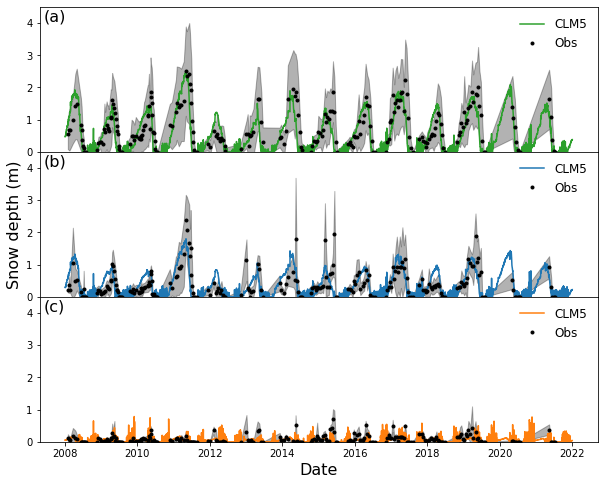

In [27]:
#add points for each observation
colorlist = ['tab:green','tab:blue','tab:orange']

x_clm = ds1.indexes['time'].to_datetimeindex()
#x_clm = x_clm.where(ds1['time.year']>2009).where(ds1['time.year']<2013)
y_clm = ds1.SNOW_DEPTH.sel(sim='Saddle')
x_obs = dsSNO['date'].where(dsSNO['date.year']>2007)
y_obs = dsSNO.avg_date_depth/100
y_obsSD = dsSNO.sd_date_depth/100

fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw={'wspace': 0, 'hspace': 0}, figsize=(10,8))

for i in range(len(ds1.column)):
        
    y1 = y_clm.isel(column=i)
    y2 = y_obs.isel(veg_com=i)
    y2SD = y_obsSD.isel(veg_com=i)
    
    axs[i].plot(x_clm, y1, label="CLM5", color=colorlist[i]) ;
    axs[i].plot(x_obs, y2, '.', label="Obs", color='k') ;
    #axs[i].plot(x_obs, y2, label="Obs", color='k') ;
    axs[i].fill_between(x_obs, y2 - y2SD, y2 + y2SD, alpha=0.3, color="k")
                     
    axs[i].set_ylim([0,4.5])
    axs[i].legend(('CLM5','Obs'), frameon=False, fontsize='large', loc='upper right')
    axs[i].annotate(panel[i], xy=(15, 135), xycoords='axes points',
            ha='center', va='center',fontsize=16)
    
    if i == 1:
        axs[i].set_ylabel('Snow depth (m)', fontsize=16)
    
    if i == 2:
        axs[i].set_xlabel('Date', fontsize=16)

#fig.tight_layout()        

plt.savefig(out_dir+'FigS1.pdf');

#### Time series of sensor network data (soil temperature and moisture) and model output (Figure S2a and S2b)

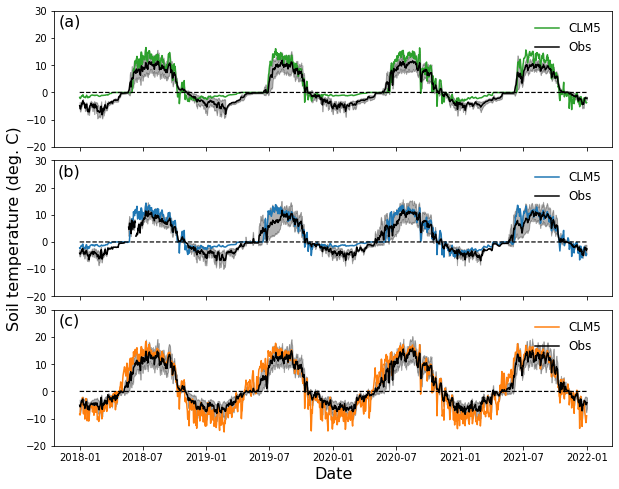

In [44]:
# Plot obs vs CLM soil moisture, 2018-2021
colorlist = ['tab:green','tab:blue','tab:orange']
vegtitle = ['Moist Meadow', 'Wet Meadow', 'Dry Meadow']
x = ((ds1.TSOI.sel(sim='Saddle').isel(levgrnd=1))-273.15).where(ds1.TSOI['time.year']>2017)
x = x.resample(time='D').mean('time')
TSOI_OBS = dsSOI.soiltemp_upper_avg
xOBS_SD = dsSOIstd.soiltemp_upper_avg

xCLM = x.indexes['time'].to_datetimeindex()
xOBS = TSOI_OBS['date'].where(TSOI_OBS['date.year']>2017)

fig, axs = plt.subplots(3, 1, gridspec_kw={'wspace': 0, 'hspace': 0.1}, sharex=True, figsize=(10,8))

for i in range(len(ds1.column)):
    
    y1 =  x.isel(column=i)
    y2 = TSOI_OBS.isel(veg_com=i)
    y2SD = xOBS_SD.isel(veg_com=i)

    axs[i].plot(xCLM, y1, color=colorlist[i]) ;
    axs[i].plot(xOBS, y2, color='k') ;
    axs[i].fill_between(xOBS, y2 - y2SD, y2 + y2SD, alpha=0.3, color="k") 
    
    axs[i].set_ylim([-20, 30])
    axs[i].plot(xOBS, np.zeros(5352), '--', linewidth=1.2, color='k')
    axs[i].legend(('CLM5','Obs'), frameon=False, fontsize='large', loc='upper right')
    axs[i].annotate(panel[i], xy=(15, 125), xycoords='axes points',
                ha='center', va='center',fontsize=16) 
    
    if i == 1:
        axs[i].set_ylabel('Soil temperature (deg. C)', fontsize=16)
    
    if i == 2:
        axs[i].set_xlabel('Date', fontsize=16)
    
#fig.tight_layout()
plt.savefig(out_dir+'FigS2_temp.pdf');

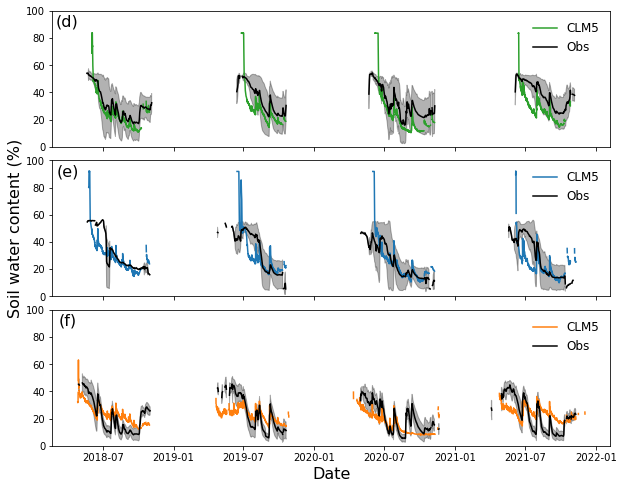

In [45]:
# Plot obs vs CLM soil moisture, 2018-2021
# mask soil temp > 0 first
colorlist = ['tab:green','tab:blue','tab:orange']
vegtitle = ['Moist Meadow', 'Wet Meadow', 'Dry Meadow']

TSOI = ds1.TSOI.isel(levgrnd=1) - 273.15
H2OSOI_Sad_temp = ds1.H2OSOI.where(TSOI>0).sel(sim='Saddle').isel(levsoi=1)
H2OSOI_Sad_temp = (H2OSOI_Sad_temp*100).where(H2OSOI_Sad_temp['time.year']>2017)
H2OSOI_OBS = dsSOI.soilmoisture_upper_avg.where(dsSOI.soiltemp_upper_avg>0)
H2OSOI_OBS_SD = dsSOIstd.soilmoisture_upper_avg.where(dsSOIstd.soiltemp_upper_avg>0)

xCLM = H2OSOI_Sad_temp.indexes['time'].to_datetimeindex()
xOBS = H2OSOI_OBS['date'].where(H2OSOI_OBS['date.year']>2017)

fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw={'wspace': 0, 'hspace': 0.1}, figsize=(10,8))

for i in range(len(H2OSOI_Sad_temp.column)):
    
    y1 =  H2OSOI_Sad_temp.isel(column=i)
    y2 = H2OSOI_OBS.isel(veg_com=i)
    y2SD = H2OSOI_OBS_SD .isel(veg_com=i)

    axs[i].plot(xCLM, y1, color=colorlist[i]) ;
    axs[i].plot(xOBS, y2, color='k') ;
    axs[i].fill_between(xOBS, y2 - y2SD, y2 + y2SD, alpha=0.3, color="k") 
    
    axs[i].set_ylim([0, 100])
    axs[i].legend(('CLM5','Obs'), frameon=False, fontsize='large', loc='upper right')
    axs[i].annotate(panel2[i], xy=(15, 125), xycoords='axes points',
                ha='center', va='center',fontsize=16) 
    
    if i == 1:
        axs[i].set_ylabel('Soil water content (%)', fontsize=16)
    
    if i == 2:
        axs[i].set_xlabel('Date', fontsize=16)
    
#fig.tight_layout()
plt.savefig(out_dir+'FigS2_moisture.pdf');

#### Figure 3: ANPP and GPP boxplots

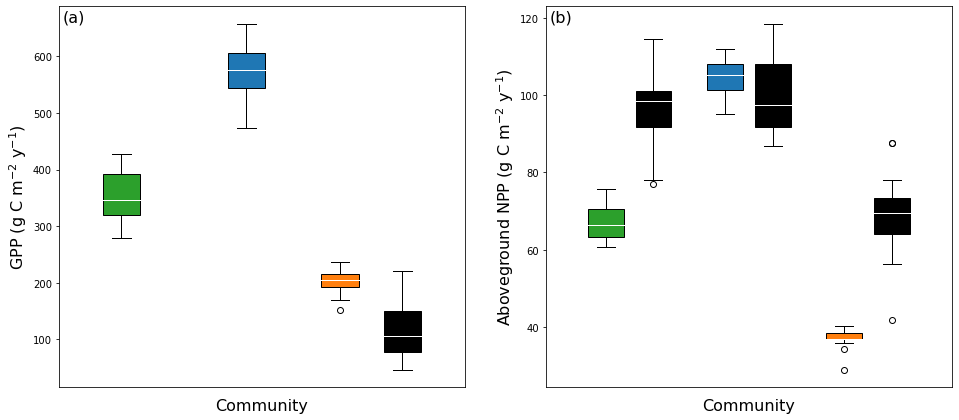

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False,
                        figsize=(16,7))

# 1st panel - GPP
annGPP1 = ds1.GPP.sel(sim='Saddle').groupby(ds1['time.year']).mean()*365
obsGPP = temp.groupby(temp['time.year']).mean()*365 

box1 = ax1.boxplot(annGPP1, patch_artist=True, boxprops=dict(facecolor="tab:orange", color="k"), medianprops=dict(color='white'), 
                   whiskerprops=dict(color='k'), capprops=dict(color='k'), flierprops=dict(color='k'), positions=[1,2,2.75], widths=(0.3, 0.3, 0.3)); #
box2 = ax1.boxplot(obsGPP, patch_artist=True, boxprops=dict(facecolor="k", color="k"), medianprops=dict(color='white'),
                 whiskerprops=dict(color='k'), capprops=dict(color='k'), positions=[3.25], widths=(0.3));#
    
ax1.xaxis.set_ticks_position('none') 
ax1.set(xticklabels=[])

ax1.set_xlabel("Community", fontsize=16)
ax1.set_ylabel("GPP (g C $\mathregular{m^{-2}}$ $\mathregular{y^{-1}}$)", fontsize=16)
ax1.annotate(text='(a)', xy=(15, 370), xycoords='axes points',
                ha='center', va='center',fontsize=16) 

colors = ['tab:green', 'tab:blue', 'tab:orange']
for bplot in (box1):
    for patch, color in zip(box1['boxes'], colors):
        patch.set_facecolor(color)
        
        
# 2nd panel - ANPP
annNPP1 = ds1['AGNPP'].sel(sim='Saddle').groupby(ds1['time.year']).mean()*3600*24*365
obsNPP = dsNPP.where(dsNPP['year']>2007).NPP/2 # select years 2008-2020 and divide by 2 to conver to gC/m2 from gDW
mask = ~np.isnan(obsNPP) # find the nans - boxplot doesn't allow them
obsNPP_filtered = [d[m] for d, m in zip(obsNPP.T, mask.T)] # remove the nans

box3 = ax2.boxplot(annNPP1, patch_artist=True, boxprops=dict(facecolor="tab:red", color="k"), medianprops=dict(color='white'), 
                   whiskerprops=dict(color='k'), capprops=dict(color='k'), flierprops=dict(color='k'), positions=[0.8,1.8,2.8], widths=(0.3, 0.3, 0.3));
box4 = ax2.boxplot(obsNPP_filtered, patch_artist=True, boxprops=dict(facecolor="k", color="k"), medianprops=dict(color='white'),
                 whiskerprops=dict(color='k'), capprops=dict(color='k'), positions=[1.2,2.2,3.2], widths=(0.3));

ax2.xaxis.set_ticks_position('none') 
ax2.set(xticklabels=[])

ax2.set_xlabel("Community", fontsize=16)
ax2.set_ylabel("Aboveground NPP (g C $\mathregular{m^{-2}}$ $\mathregular{y^{-1}}$)", fontsize=16)
ax2.annotate(text='(b)', xy=(15, 370), xycoords='axes points',
                ha='center', va='center',fontsize=16) 

colors = ['tab:green', 'tab:blue', 'tab:orange']
for bplot in (box1):
    for patch, color in zip(box3['boxes'], colors):
        patch.set_facecolor(color)

plt.savefig(out_dir+'Fig3.pdf');

#### Figures 4 and 5 (north and south simulations) - snow, runoff, soil moisture, soil temperature

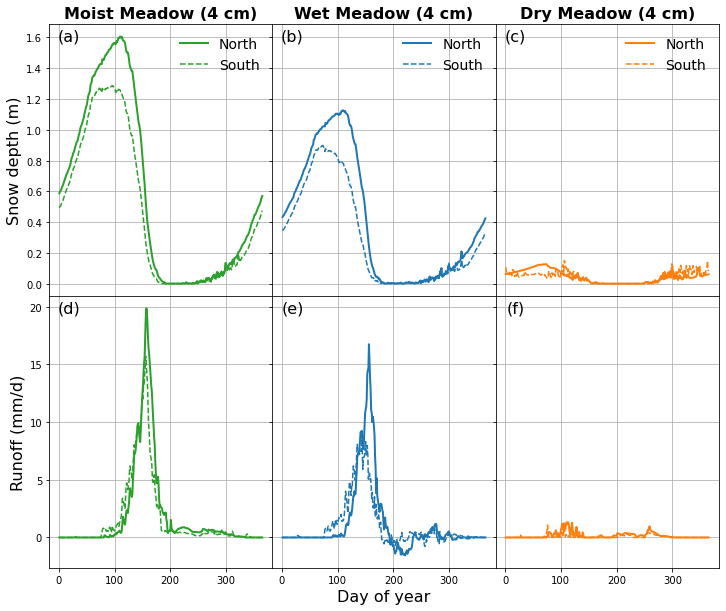

In [25]:
# reindex aspect
aspect  = ["North","South"]
ds1Aspect = ds1Aspect.reindex({'sim': aspect})

colorlist = ['tab:green','tab:blue','tab:orange'] 
veglist = ['Moist Meadow (4 cm)', 'Wet Meadow (4 cm)', 'Dry Meadow (4 cm)']

SNOW_DEPTH = ds1Aspect.SNOW_DEPTH
QRUNOFF = ds1Aspect.QRUNOFF*3600*24
clmVARS = [SNOW_DEPTH,QRUNOFF]
nyear = len(years) 
nlev = 1   

x1 = ds1Aspect['time.dayofyear']

fig, axs = plt.subplots(2, 3, 
                    sharey='row', sharex=True,
                    gridspec_kw={'wspace': 0, 'hspace': 0},
                    figsize=(12,10)) 
for j in range(len(clmVARS)):    
    for v in range(3):  
        for i in range(len(ds1Aspect.sim)):
            x = clmVARS[j].groupby(x1).mean()
            y = x.isel(column=v, sim=i)
 
            if v == 0 and i == 0:
                axs[j,v].plot(x['dayofyear'], y, '-', linewidth=2, color=colorlist[0])
            if v == 0 and i == 1:
                axs[j,v].plot(x['dayofyear'], y, '--', color=colorlist[0])
            if v == 1 and i == 0:
                axs[j,v].plot(x['dayofyear'], y, '-', linewidth=2, color=colorlist[1])
            if v == 1 and i == 1:
                axs[j,v].plot(x['dayofyear'], y, '--', color=colorlist[1])
            if v == 2 and i == 0:
                axs[j,v].plot(x['dayofyear'], y, '-', linewidth=2, color=colorlist[2])
            if v == 2 and i == 1:
                axs[j,v].plot(x['dayofyear'], y, '--', color=colorlist[2])
    
        axs[j,v].grid();
        if j == 0 and v == 0:
            axs[j,v].set_ylabel('Snow depth (m)', fontsize=16);
        if j == 1 and v == 0:
            axs[j,v].set_ylabel('Runoff (mm/d)', fontsize=16);
        if j==1 and v == 1:
            axs[j,v].set_xlabel('Day of year', fontsize=16); 
        if j==0:
            axs[j,v].set_title(veglist[v], loc='center', fontsize=16, fontweight='bold')
            axs[j,v].annotate(panel[v], xy=(20, 260), xycoords='axes points', ha='center', va='center',fontsize=16) 
            axs[j,v].legend(aspect, frameon=False,fontsize=14,loc='upper right')
        if j==1:       
            axs[j,v].annotate(panel2[v], xy=(20, 260), xycoords='axes points', ha='center', va='center',fontsize=16) 
       
plt.savefig(out_dir+'Fig4.pdf');

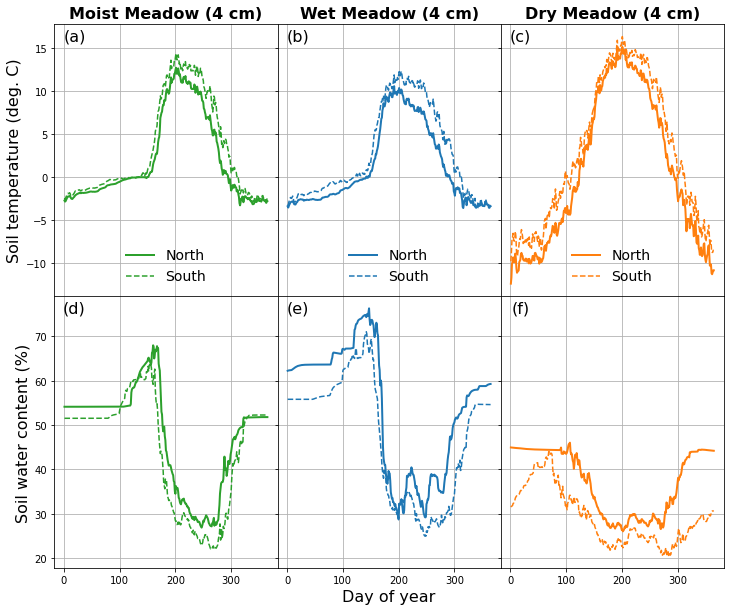

In [24]:
# reindex aspect
aspect  = ["North","South"]
ds1Aspect = ds1Aspect.reindex({'sim': aspect})

colorlist = ['tab:green','tab:blue','tab:orange'] 
veglist = ['Moist Meadow (4 cm)', 'Wet Meadow (4 cm)', 'Dry Meadow (4 cm)']

H2OSOI = ds1Aspect.H2OSOI
TSOI = ds1Aspect.TSOI
clmVARS = [TSOI,H2OSOI]
nyear = len(years) 
nlev = 1   

x1 = ds1Aspect['time.dayofyear']

fig, axs = plt.subplots(2, 3, 
                    sharey='row', sharex=True,
                    gridspec_kw={'wspace': 0, 'hspace': 0},
                    figsize=(12,10)) 

for j in range(len(clmVARS)):    
    for v in range(3):  
        for i in range(len(ds1Aspect.sim)):
            x = clmVARS[j].groupby(x1).mean()
            
            if j == 0:
                y = x.isel(levgrnd=nlev).isel(column=v, sim=i)-273.15
            else:
                y = x.isel(levsoi=nlev).isel(column=v, sim=i)*100
 
            if v == 0 and i == 0:
                axs[j,v].plot(x['dayofyear'], y, '-', linewidth=2, color=colorlist[0])
            if v == 0 and i == 1:
                axs[j,v].plot(x['dayofyear'], y, '--', color=colorlist[0])
            if v == 1 and i == 0:
                axs[j,v].plot(x['dayofyear'], y, '-', linewidth=2, color=colorlist[1])
            if v == 1 and i == 1:
                axs[j,v].plot(x['dayofyear'], y, '--', color=colorlist[1])
            if v == 2 and i == 0:
                axs[j,v].plot(x['dayofyear'], y, '-', linewidth=2, color=colorlist[2])
            if v == 2 and i == 1:
                axs[j,v].plot(x['dayofyear'], y, '--', color=colorlist[2])
                
        axs[j,v].grid();
        if j == 0 and v == 0:
            axs[j,v].set_ylabel('Soil temperature (deg. C)', fontsize=16);
        if j == 1 and v == 0:
            axs[j,v].set_ylabel('Soil water content (%)', fontsize=16);
        if j==1 and v == 1:
            axs[j,v].set_xlabel('Day of year', fontsize=16); 
        if j==0:
            axs[j,v].set_title(veglist[v], loc='center', fontsize=16, fontweight='bold')
            axs[j,v].annotate(panel[v], xy=(20, 260), xycoords='axes points', ha='center', va='center',fontsize=16) 
            axs[j,v].legend(aspect, frameon=False,fontsize=14,loc='lower center')
        if j==1:       
            axs[j,v].annotate(panel2[v], xy=(20, 260), xycoords='axes points', ha='center', va='center',fontsize=16) 

plt.savefig(out_dir+'Fig5.pdf');

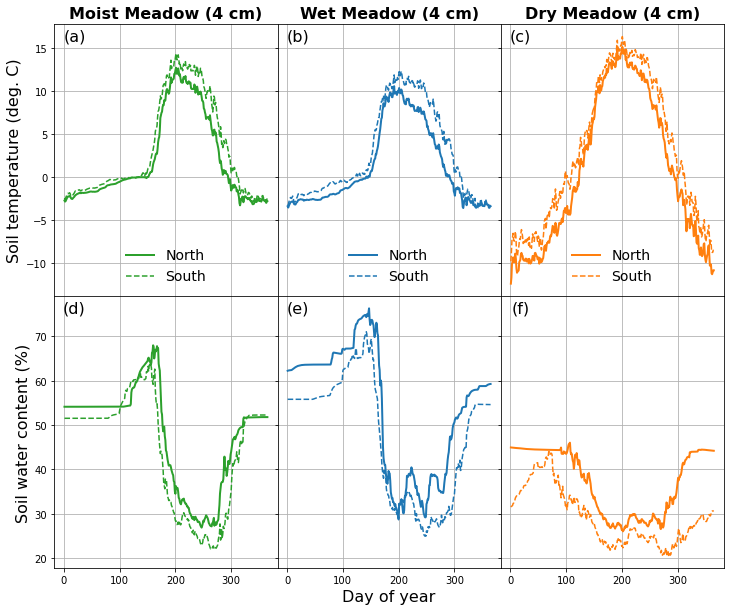

In [16]:
# reindex aspect
aspect  = ["North","South"]
ds1Aspect = ds1Aspect.reindex({'sim': aspect})

colorlist = ['tab:green','tab:blue','tab:orange'] 
veglist = ['Moist Meadow (4 cm)', 'Wet Meadow (4 cm)', 'Dry Meadow (4 cm)']

H2OSOI = ds1Aspect.H2OSOI
TSOI = ds1Aspect.TSOI
clmVARS = [TSOI,H2OSOI]
nyear = len(years) 
nlev = 1   

x1 = ds1Aspect['time.dayofyear']

fig, axs = plt.subplots(2, 3, 
                    sharey='row', sharex=True,
                    gridspec_kw={'wspace': 0, 'hspace': 0},
                    figsize=(12,10)) 

for j in range(len(clmVARS)):    
    for v in range(3):  
        for i in range(len(ds1Aspect.sim)):
            x = clmVARS[j].groupby(x1).mean()
            
            if j == 0:
                y = x.isel(levgrnd=nlev).isel(column=v, sim=i)-273.15
            else:
                y = x.isel(levsoi=nlev).isel(column=v, sim=i)*100
 
            if v == 0 and i == 0:
                axs[j,v].plot(x['dayofyear'], y, '-', linewidth=2, color=colorlist[0])
            if v == 0 and i == 1:
                axs[j,v].plot(x['dayofyear'], y, '--', color=colorlist[0])
            if v == 1 and i == 0:
                axs[j,v].plot(x['dayofyear'], y, '-', linewidth=2, color=colorlist[1])
            if v == 1 and i == 1:
                axs[j,v].plot(x['dayofyear'], y, '--', color=colorlist[1])
            if v == 2 and i == 0:
                axs[j,v].plot(x['dayofyear'], y, '-', linewidth=2, color=colorlist[2])
            if v == 2 and i == 1:
                axs[j,v].plot(x['dayofyear'], y, '--', color=colorlist[2])
                
        axs[j,v].grid();
        if j == 0 and v == 0:
            axs[j,v].set_ylabel('Soil temperature (deg. C)', fontsize=16);
        if j == 1 and v == 0:
            axs[j,v].set_ylabel('Soil water content (%)', fontsize=16);
        if j==1 and v == 1:
            axs[j,v].set_xlabel('Day of year', fontsize=16); 
        if j==0:
            axs[j,v].set_title(veglist[v], loc='center', fontsize=16, fontweight='bold')
            axs[j,v].annotate(panel[v], xy=(20, 260), xycoords='axes points', ha='center', va='center',fontsize=16) 
            axs[j,v].legend(aspect, frameon=False,fontsize=14,loc='lower center')
        if j==1:       
            axs[j,v].annotate(panel2[v], xy=(20, 260), xycoords='axes points', ha='center', va='center',fontsize=16) 

plt.savefig(out_dir+'Fig5.pdf');

### Extending simulations to 2100

#### Looking at snow, runoff, soil moisture, and GPP for each community and aspect
Figs 6 and S3, S4

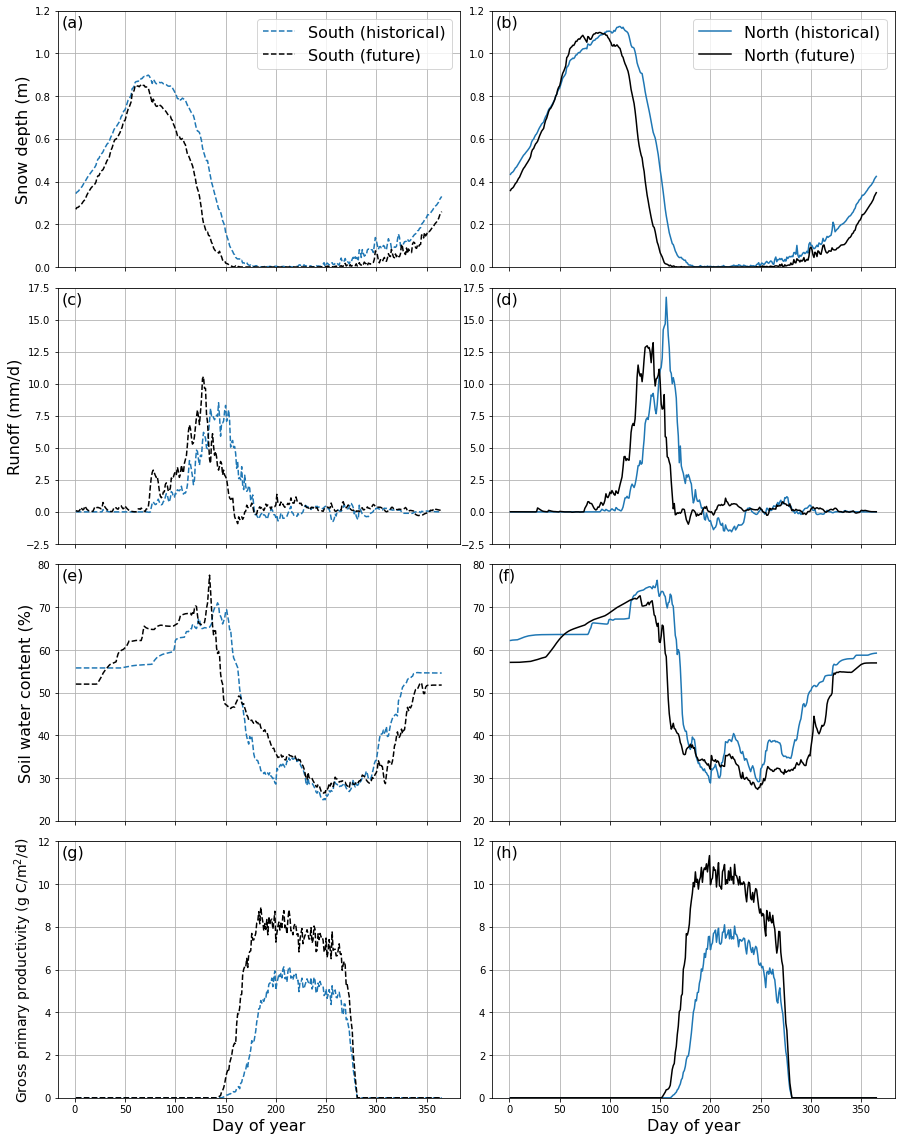

In [56]:
var = ['SNOW_DEPTH','QRUNOFF','H2OSOI','GPP']
colorlist = ['tab:blue','k']
aspect1  = ["South (historical)","South (future)"]
aspect2  = ["North (historical)","North (future)"]

fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True, gridspec_kw={'wspace': 0.08, 'hspace': 0.08}, figsize=[15,20])

for v in range(len(var)):
    for i in range(len(ds1Aspect.sim)):
        plt.subplot(4,2,(v*2+i+1))
        plotVar1 = ds1Aspect[var[v]].isel(column=1).groupby("time.dayofyear").mean('time')
        plotVar2 = ds2Aspect[var[v]].isel(column=1).groupby("time.dayofyear").mean('time')
        plt.grid()
        plt.annotate(panel[(v*2+i)], xy=(15, 245), xycoords='axes points', ha='center', va='center',fontsize=16);
        
        if v == 0 and i == 0:
            plotVar1.isel(sim=i).plot(label=aspect1[0], linestyle='--', color=colorlist[0]);
            plotVar2.isel(sim=i).plot(label=aspect1[1], linestyle='--', color=colorlist[1]);
            plt.ylim(0,1.2)
            plt.ylabel('Snow depth (m)', fontsize=16)
            plt.xlabel('')
            plt.legend(fontsize=16)
            
        if v == 0 and i == 1:
            plotVar1.isel(sim=i).plot(label=aspect2[0], linestyle='-', color=colorlist[0]);
            plotVar2.isel(sim=i).plot(label=aspect2[1], linestyle='-', color=colorlist[1]);
            plt.ylim(0,1.2)
            plt.ylabel('')
            plt.xlabel('')
            plt.legend(fontsize=16) 
            
        if v == 1 and i == 0:
            (plotVar1*3600*24).isel(sim=i).plot(label=aspect1[0], linestyle='--', color=colorlist[0]);
            (plotVar2*3600*24).isel(sim=i).plot(label=aspect1[1], linestyle='--', color=colorlist[1]);
            plt.ylim(-2.5,17.5)
            plt.ylabel('Runoff (mm/d)', fontsize=16)
            plt.xlabel('')
            
        if v == 1 and i == 1:
            (plotVar1*3600*24).isel(sim=i).plot(label=aspect2[0], linestyle='-', color=colorlist[0]);
            (plotVar2*3600*24).isel(sim=i).plot(label=aspect2[1], linestyle='-', color=colorlist[1]);
            plt.ylim(-2.5,17.5)
            plt.ylabel('')
            plt.xlabel('')
            
        if v == 2 and i == 0:
            (plotVar1*100).isel(sim=i, levsoi=1).plot(label=aspect1[0], linestyle='--', color=colorlist[0]);
            (plotVar2*100).isel(sim=i, levsoi=1).plot(label=aspect1[1], linestyle='--', color=colorlist[1]);
            plt.ylim(20,80)
            plt.ylabel('Soil water content (%)', fontsize=16)
            plt.xlabel('')

        if v == 2 and i == 1:
            (plotVar1*100).isel(sim=i, levsoi=1).plot(label=aspect2[0], linestyle='-', color=colorlist[0]);
            (plotVar2*100).isel(sim=i, levsoi=1).plot(label=aspect2[1], linestyle='-', color=colorlist[1]);
            plt.ylim(20,80)
            plt.ylabel('')
            plt.xlabel('')
            
        if v == 3 and i == 0:
            (plotVar1*3600*24).isel(sim=i).plot(label=aspect1[0], linestyle='--', color=colorlist[0]); 
            (plotVar2*3600*24).isel(sim=i).plot(label=aspect1[1], linestyle='--', color=colorlist[1]);
            plt.ylim(0,12)
            plt.ylabel('Gross primary productivity (g C/$\mathregular{m^{2}}$/d)', fontsize=14)
            plt.xlabel('Day of year', fontsize=16)
            
        if v == 3 and i == 1:          
            (plotVar1*3600*24).isel(sim=i).plot(label=aspect2[0], linestyle='-', color=colorlist[0]);
            (plotVar2*3600*24).isel(sim=i).plot(label=aspect2[1], linestyle='-', color=colorlist[1]);
            plt.ylim(0,12)
            plt.ylabel('')
            plt.xlabel('Day of year', fontsize=16)
            
        plt.title('')

#plt.savefig(out_dir+'Fig6.pdf');

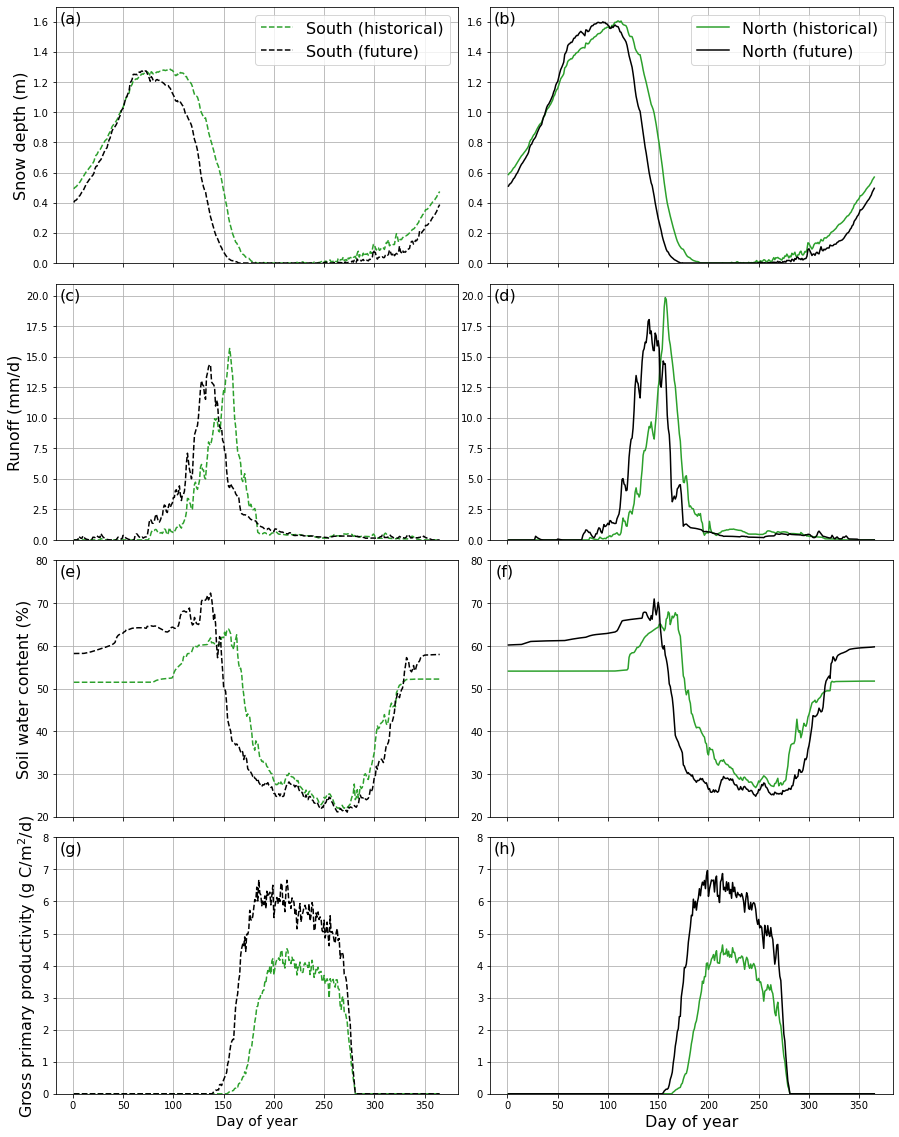

In [32]:
var = ['SNOW_DEPTH','QRUNOFF','H2OSOI','GPP']
colorlist = ['tab:green','k']
aspect1  = ["South (historical)","South (future)"]
aspect2  = ["North (historical)","North (future)"]

fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True, gridspec_kw={'wspace': 0.08, 'hspace': 0.08}, figsize=[15,20])

for v in range(len(var)):
    for i in range(len(ds1Aspect.sim)):
        plt.subplot(4,2,(v*2+i+1))
        plotVar1 = ds1Aspect[var[v]].isel(column=0).groupby("time.dayofyear").mean('time')
        plotVar2 = ds2Aspect[var[v]].isel(column=0).groupby("time.dayofyear").mean('time')
        plt.grid()
        plt.annotate(panel[(v*2+i)], xy=(15, 245), xycoords='axes points', ha='center', va='center',fontsize=16);
        
        if v == 0 and i == 0:
            plotVar1.isel(sim=i).plot(label=aspect1[0], linestyle='--', color=colorlist[0]);
            plotVar2.isel(sim=i).plot(label=aspect1[1], linestyle='--', color=colorlist[1]);
            plt.ylim(0,1.7)
            plt.ylabel('Snow depth (m)', fontsize=16)
            plt.xlabel('')
            plt.legend(fontsize=16)
            
        if v == 0 and i == 1:
            plotVar1.isel(sim=i).plot(label=aspect2[0], linestyle='-', color=colorlist[0]);
            plotVar2.isel(sim=i).plot(label=aspect2[1], linestyle='-', color=colorlist[1]);
            plt.ylim(0,1.7)
            plt.ylabel('')
            plt.xlabel('')
            plt.legend(fontsize=16) 
            
        if v == 1 and i == 0:
            (plotVar1*3600*24).isel(sim=i).plot(label=aspect1[0], linestyle='--', color=colorlist[0]);
            (plotVar2*3600*24).isel(sim=i).plot(label=aspect1[1], linestyle='--', color=colorlist[1]);
            plt.ylim(0,21)
            plt.ylabel('Runoff (mm/d)', fontsize=16)
            plt.xlabel('')
            
        if v == 1 and i == 1:
            (plotVar1*3600*24).isel(sim=i).plot(label=aspect2[0], linestyle='-', color=colorlist[0]);
            (plotVar2*3600*24).isel(sim=i).plot(label=aspect2[1], linestyle='-', color=colorlist[1]);
            plt.ylim(0,21)
            plt.ylabel('')
            plt.xlabel('')
            
        if v == 2 and i == 0:
            (plotVar1*100).isel(sim=i, levsoi=1).plot(label=aspect1[0], linestyle='--', color=colorlist[0]);
            (plotVar2*100).isel(sim=i, levsoi=1).plot(label=aspect1[1], linestyle='--', color=colorlist[1]);
            plt.ylim(20,80)
            plt.ylabel('Soil water content (%)', fontsize=16)
            plt.xlabel('')

        if v == 2 and i == 1:
            (plotVar1*100).isel(sim=i, levsoi=1).plot(label=aspect2[0], linestyle='-', color=colorlist[0]);
            (plotVar2*100).isel(sim=i, levsoi=1).plot(label=aspect2[1], linestyle='-', color=colorlist[1]);
            plt.ylim(20,80)
            plt.ylabel('')
            plt.xlabel('')
            
        if v == 3 and i == 0:
            (plotVar1*3600*24).isel(sim=i).plot(label=aspect1[0], linestyle='--', color=colorlist[0]); 
            (plotVar2*3600*24).isel(sim=i).plot(label=aspect1[1], linestyle='--', color=colorlist[1]);
            plt.ylim(0,8)
            plt.ylabel('Gross primary productivity (g C/$\mathregular{m^{2}}$/d)', fontsize=16)
            plt.xlabel('Day of year', fontsize=14)
            
        if v == 3 and i == 1:          
            (plotVar1*3600*24).isel(sim=i).plot(label=aspect2[0], linestyle='-', color=colorlist[0]);
            (plotVar2*3600*24).isel(sim=i).plot(label=aspect2[1], linestyle='-', color=colorlist[1]);
            plt.ylim(0,8)
            plt.ylabel('')
            plt.xlabel('Day of year', fontsize=16)
            
        plt.title('')
        
#plt.savefig(out_dir+'FigS3.pdf');

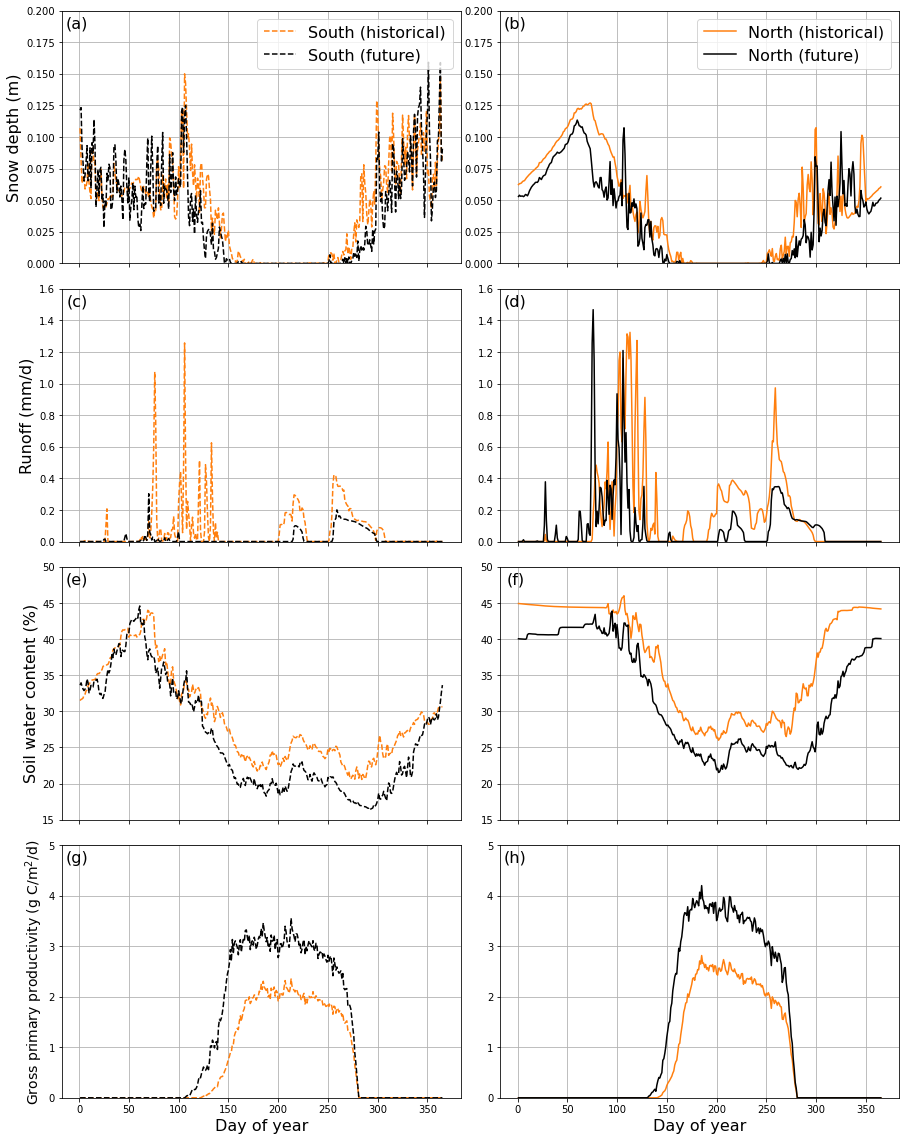

In [33]:
var = ['SNOW_DEPTH','QRUNOFF','H2OSOI','GPP']
colorlist = ['tab:orange','k']
aspect1  = ["South (historical)","South (future)"]
aspect2  = ["North (historical)","North (future)"]

fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True, gridspec_kw={'wspace': 0.1, 'hspace': 0.1}, figsize=[15,20])

for v in range(len(var)):
    for i in range(len(ds1Aspect.sim)):
        plt.subplot(4,2,(v*2+i+1))
        plotVar1 = ds1Aspect[var[v]].isel(column=2).groupby("time.dayofyear").mean('time')
        plotVar2 = ds2Aspect[var[v]].isel(column=2).groupby("time.dayofyear").mean('time')
        plt.grid()
        plt.annotate(panel[(v*2+i)], xy=(15, 240), xycoords='axes points', ha='center', va='center',fontsize=16);
        
        if v == 0 and i == 0:
            plotVar1.isel(sim=i).plot(label=aspect1[0], linestyle='--', color=colorlist[0]);
            plotVar2.isel(sim=i).plot(label=aspect1[1], linestyle='--', color=colorlist[1]);
            plt.ylim(0,0.2)
            plt.ylabel('Snow depth (m)', fontsize=16)
            plt.xlabel('')
            plt.legend(fontsize=16,loc='upper right')
            
        if v == 0 and i == 1:
            plotVar1.isel(sim=i).plot(label=aspect2[0], linestyle='-', color=colorlist[0]);
            plotVar2.isel(sim=i).plot(label=aspect2[1], linestyle='-', color=colorlist[1]);
            plt.ylim(0,0.2)
            plt.ylabel('')
            plt.xlabel('')
            plt.legend(fontsize=16) 
            
        if v == 1 and i == 0:
            (plotVar1*3600*24).isel(sim=i).plot(label=aspect1[0], linestyle='--', color=colorlist[0]);
            (plotVar2*3600*24).isel(sim=i).plot(label=aspect1[1], linestyle='--', color=colorlist[1]);
            plt.ylim(0,1.6)
            plt.ylabel('Runoff (mm/d)', fontsize=16)
            plt.xlabel('')
            
        if v == 1 and i == 1:
            (plotVar1*3600*24).isel(sim=i).plot(label=aspect2[0], linestyle='-', color=colorlist[0]);
            (plotVar2*3600*24).isel(sim=i).plot(label=aspect2[1], linestyle='-', color=colorlist[1]);
            plt.ylim(0,1.6)
            plt.ylabel('')
            plt.xlabel('')
            
        if v == 2 and i == 0:
            (plotVar1*100).isel(sim=i, levsoi=1).plot(label=aspect1[0], linestyle='--', color=colorlist[0]);
            (plotVar2*100).isel(sim=i, levsoi=1).plot(label=aspect1[1], linestyle='--', color=colorlist[1]);
            plt.ylim(15,50)
            plt.ylabel('Soil water content (%)', fontsize=16)
            plt.xlabel('')

        if v == 2 and i == 1:
            (plotVar1*100).isel(sim=i, levsoi=1).plot(label=aspect2[0], linestyle='-', color=colorlist[0]);
            (plotVar2*100).isel(sim=i, levsoi=1).plot(label=aspect2[1], linestyle='-', color=colorlist[1]);
            plt.ylim(15,50)
            plt.ylabel('')
            plt.xlabel('')
            
        if v == 3 and i == 0:
            (plotVar1*3600*24).isel(sim=i).plot(label=aspect1[0], linestyle='--', color=colorlist[0]); 
            (plotVar2*3600*24).isel(sim=i).plot(label=aspect1[1], linestyle='--', color=colorlist[1]);
            plt.ylim(0,5)
            plt.ylabel('Gross primary productivity (g C/$\mathregular{m^{2}}$/d)', fontsize=14)
            plt.xlabel('Day of year', fontsize=16)
            
        if v == 3 and i == 1:          
            (plotVar1*3600*24).isel(sim=i).plot(label=aspect2[0], linestyle='-', color=colorlist[0]);
            (plotVar2*3600*24).isel(sim=i).plot(label=aspect2[1], linestyle='-', color=colorlist[1]);
            plt.ylim(0,5)
            plt.ylabel('')
            plt.xlabel('Day of year', fontsize=16)
            
        plt.title('')
        
#plt.savefig(out_dir+'FigS4.pdf');

#### Fig. 7 future - historical diffs boxplot

In [24]:
# extract annual air temp
meanTBOT_2015 = ds1_2015.TBOT.sel(sim="South").groupby("time.year").mean('time')
meanTBOT_2100 = ds2_2100.TBOT.sel(sim="South").groupby("time.year").mean('time')
# future - control TSOI
TBOT_diff = meanTBOT_2100.values - meanTBOT_2015.values
mean_TBOT_chg = TBOT_diff.mean()
mean_TBOT_chg

3.5242794

In [25]:
# extract annual soil temp for boxplot
meanTSOI_2015_S = ds1_2015.TSOI.sel(sim="South").isel(levgrnd=0).groupby("time.year").mean('time')
meanTSOI_2100_S = ds2_2100.TSOI.sel(sim="South").isel(levgrnd=0).groupby("time.year").mean('time')

meanTSOI_2015_N = ds1_2015.TSOI.sel(sim="North").isel(levgrnd=0).groupby("time.year").mean('time')
meanTSOI_2100_N = ds2_2100.TSOI.sel(sim="North").isel(levgrnd=0).groupby("time.year").mean('time')

In [26]:
# future - control TSOI
TSOI_diff_S = meanTSOI_2100_S.values - meanTSOI_2015_S.values
TSOI_diff_N = meanTSOI_2100_N.values - meanTSOI_2015_N.values

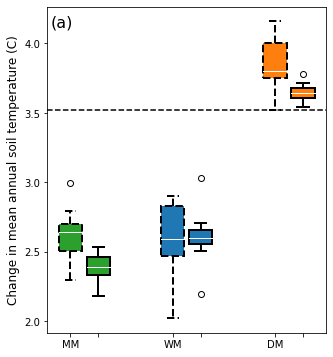

In [48]:
fig, ax = plt.subplots(1,1, sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        figsize=(5,6))

labels1 = ['', '', '']
labels2 = ['MM', 'WM', 'DM'] # set labels for x axis

box1 = plt.boxplot(TSOI_diff_S, labels=labels2, patch_artist=True, boxprops=dict(linestyle='--', linewidth=2), medianprops=dict(color='white'),
                   whiskerprops=dict(linestyle='--', linewidth=2), capprops=dict(linestyle='--', linewidth=2), positions=[1,3.2,5.4]);
box2 = plt.boxplot(TSOI_diff_N, labels=labels1, patch_artist=True, boxprops=dict(linewidth=2), medianprops=dict(color='white'),
                   whiskerprops=dict(linewidth=2), capprops=dict(linewidth=2), positions=[1.6,3.8,6]);

plt.axhline(y = mean_TBOT_chg, color = 'k', linestyle = '--')
plt.ylabel("Change in mean annual soil temperature (C)", fontsize='large')
plt.annotate(text='(a)', xy=(15, 310), xycoords='axes points',
                ha='center', va='center',fontsize=16) 

# change colors by community
colors = ['tab:green', 'tab:blue', 'tab:orange']
for bplot in (box1):
    for patch, color in zip(box1['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_linestyle('dashed')
for bplot in (box2):
    for patch, color in zip(box2['boxes'], colors):
        patch.set_facecolor(color)     
        patch.set_linestyle('solid')

plt.show()

In [30]:
# calculate growing season soil moisture
gs_H2OSOI_2015_S = ds1_2015.H2OSOI.isel(levsoi=1).where(ds1_2015.ELAI>0)
gs_H2OSOI_2015_S = gs_H2OSOI_2015_S.sel(sim="South").groupby("time.year").mean('time')
gs_H2OSOI_2100_S = ds2_2100.H2OSOI.isel(levsoi=1).where(ds2_2100.ELAI>0)
gs_H2OSOI_2100_S = gs_H2OSOI_2100_S.sel(sim="South").groupby("time.year").mean('time')

gs_H2OSOI_2015_N = ds1_2015.H2OSOI.isel(levsoi=1).where(ds1_2015.ELAI>0)
gs_H2OSOI_2015_N = gs_H2OSOI_2015_N.sel(sim="North").groupby("time.year").mean('time')
gs_H2OSOI_2100_N = ds2_2100.H2OSOI.isel(levsoi=1).where(ds2_2100.ELAI>0)
gs_H2OSOI_2100_N = gs_H2OSOI_2100_N.sel(sim="North").groupby("time.year").mean('time')

In [31]:
# future - control GS H2OSOI
H2OSOI_diff_S = gs_H2OSOI_2100_S.values - gs_H2OSOI_2015_S.values
H2OSOI_diff_N = gs_H2OSOI_2100_N.values - gs_H2OSOI_2015_S.values

In [32]:
# normalize the differences
H2OSOI_diff_S_norm = H2OSOI_diff_S/gs_H2OSOI_2015_S
H2OSOI_diff_N_norm = H2OSOI_diff_N/gs_H2OSOI_2015_N

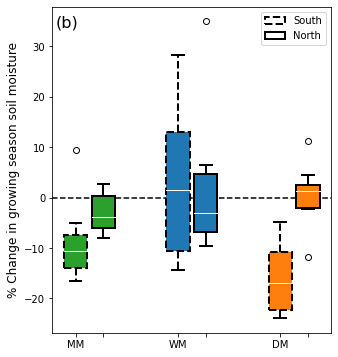

In [60]:
fig, ax = plt.subplots(1,1, sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        figsize=(5,6))

labels1 = ['', '', '']
labels2 = ['MM', 'WM', 'DM'] # set labels for x axis

box1 = plt.boxplot(H2OSOI_diff_S_norm*100, labels=labels2, patch_artist=True, boxprops=dict(linestyle='--', linewidth=2), medianprops=dict(color='white'),
                   whiskerprops=dict(linestyle='--', linewidth=2), capprops=dict(linestyle='-', linewidth=2), positions=[1,3.2,5.4]);
box2 = plt.boxplot(H2OSOI_diff_N_norm*100, labels=labels1, patch_artist=True, boxprops=dict(color='k', linewidth=2), medianprops=dict(color='white'),
                   whiskerprops=dict(linewidth=2), capprops=dict(linewidth=2), positions=[1.6,3.8,6]);

plt.ylabel("% Change in growing season soil moisture", fontsize='large')
plt.axhline(y = 0, color = 'k', linestyle = '--')
plt.annotate(text='(b)', xy=(15, 310), xycoords='axes points',
                ha='center', va='center',fontsize=16) 

# change colors by community
colors = ['tab:green', 'tab:blue', 'tab:orange']
for bplot in (box1):
    for patch, color in zip(box1['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_linestyle('dashed')
for bplot in (box2):
    for patch, color in zip(box2['boxes'], colors):
        patch.set_facecolor(color)     
        patch.set_linestyle('solid')
        
plt.legend([box1["boxes"][1], box2["boxes"][1]], ['South', 'North'], loc='upper right')
leg = ax.get_legend()
leg.legendHandles[0].set_facecolor('white')
leg.legendHandles[1].set_facecolor('white')

plt.show()

In [50]:
#south
GS_S_2015 = ds1_2015.GPP.time.dt.dayofyear.where(ds1_2015.ELAI>0).sel(sim="South") #\
FirstGPP_S_2015 = GS_S_2015.resample(time='AS').min('time',skipna=True).astype('int')
LastGPP_S_2015 = GS_S_2015.resample(time='AS').max('time',skipna=True).astype('int')
GSL_S_2015 = (LastGPP_S_2015 - FirstGPP_S_2015).astype('int')
GS_S_2100 = ds2_2100.GPP.time.dt.dayofyear.where(ds2_2100.ELAI>0).sel(sim="South") #\
FirstGPP_S_2100 = GS_S_2100.resample(time='AS').min('time',skipna=True).astype('int')
LastGPP_S_2100 = GS_S_2100.resample(time='AS').max('time',skipna=True).astype('int')
GSL_S_2100 = (LastGPP_S_2100 - FirstGPP_S_2100).astype('int')
#north
GS_N_2015 = ds1_2015.GPP.time.dt.dayofyear.where(ds1_2015.ELAI>0).sel(sim="North") #\
FirstGPP_N_2015 = GS_N_2015.resample(time='AS').min('time',skipna=True).astype('int')
LastGPP_N_2015 = GS_N_2015.resample(time='AS').max('time',skipna=True).astype('int')
GSL_N_2015 = (LastGPP_N_2015 - FirstGPP_S_2015).astype('int')
GS_N_2100 = ds2_2100.GPP.time.dt.dayofyear.where(ds2_2100.ELAI>0).sel(sim="North") #\
FirstGPP_N_2100 = GS_N_2100.resample(time='AS').min('time',skipna=True).astype('int')
LastGPP_N_2100 = GS_N_2100.resample(time='AS').max('time',skipna=True).astype('int')
GSL_N_2100 = (LastGPP_N_2100 - FirstGPP_N_2100).astype('int')

In [51]:
# future - control GSL
GSL_diff_S = GSL_S_2100.values - GSL_S_2015.values
GSL_diff_N = GSL_N_2100.values - GSL_N_2015.values

In [52]:
# normalize the differences in GSL
GSL_diff_S_norm = GSL_diff_S/GSL_S_2015.values
GSL_diff_N_norm = GSL_diff_N/GSL_N_2015.values

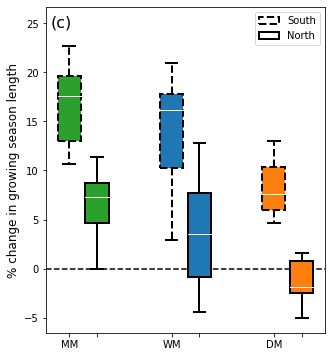

In [58]:
fig, ax = plt.subplots(1,1, sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        figsize=(5,6))

labels1 = ['', '', '']
labels2 = ['MM', 'WM', 'DM'] # set labels for x axis

box1 = plt.boxplot(GSL_diff_S_norm*100, labels=labels2, patch_artist=True, boxprops=dict(linestyle='--', linewidth=2), medianprops=dict(color='white'),
                   whiskerprops=dict(linestyle='--', linewidth=2), capprops=dict(linestyle='-', linewidth=2), positions=[1,3.2,5.4]);
box2 = plt.boxplot(GSL_diff_N_norm*100, labels=labels1, patch_artist=True, boxprops=dict(color='k', linewidth=2), medianprops=dict(color='white'),
                   whiskerprops=dict(linewidth=2), capprops=dict(linewidth=2), positions=[1.6,3.8,6]);

plt.ylabel("% change in growing season length", fontsize='large')
plt.axhline(y = 0, color = 'k', linestyle = '--')
plt.annotate(text='(c)', xy=(15, 310), xycoords='axes points',
                ha='center', va='center',fontsize=16) 

# change colors by community
colors = ['tab:green', 'tab:blue', 'tab:orange']
for bplot in (box1):
    for patch, color in zip(box1['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_linestyle('dashed')
for bplot in (box2):
    for patch, color in zip(box2['boxes'], colors):
        patch.set_facecolor(color)     
        patch.set_linestyle('solid')
        
plt.legend([box1["boxes"][1], box2["boxes"][1]], ['South', 'North'], loc='upper right')
leg = ax.get_legend()
leg.legendHandles[0].set_facecolor('white')
leg.legendHandles[1].set_facecolor('white')

plt.show()

In [54]:
# extract annual GPP
annGPP_2015_S = ds1_2015.GPP.sel(sim="South").groupby(ds1_2015['time.year']).mean()*3600*24*365
annGPP_2100_S = ds2_2100.GPP.sel(sim="South").groupby(ds2_2100['time.year']).mean()*3600*24*365
annGPP_2015_N = ds1_2015.GPP.sel(sim="North").groupby(ds1_2015['time.year']).mean()*3600*24*365
annGPP_2100_N = ds2_2100.GPP.sel(sim="North").groupby(ds2_2100['time.year']).mean()*3600*24*365

In [55]:
# future - control GPP
annGPP_diff_S = annGPP_2100_S.values - annGPP_2015_S.values
annGPP_diff_N = annGPP_2100_N.values - annGPP_2015_N.values

In [56]:
# normalize the differences
annGPP_diff_S_norm = annGPP_diff_S/annGPP_2015_S
annGPP_diff_N_norm = annGPP_diff_N/annGPP_2015_N

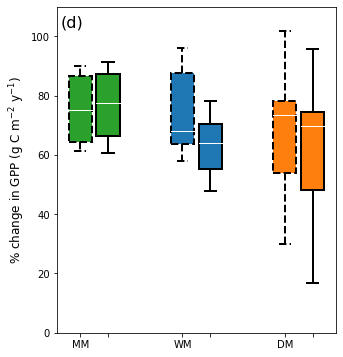

In [57]:
fig, ax = plt.subplots(1,1, sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        figsize=(5,6))

labels1 = ['', '', '']
labels2 = ['MM', 'WM', 'DM'] # set labels for x axis

box1 = plt.boxplot(annGPP_diff_S_norm*100, labels=labels2, patch_artist=True, boxprops=dict(linestyle='--', linewidth=2), medianprops=dict(color='white'),
                   whiskerprops=dict(linestyle='--', linewidth=2), capprops=dict(linestyle='--', linewidth=2), positions=[1,3.2,5.4]);
box2 = plt.boxplot(annGPP_diff_N_norm*100, labels=labels1, patch_artist=True, boxprops=dict(linewidth=2), medianprops=dict(color='white'),
                   whiskerprops=dict(linewidth=2), capprops=dict(linewidth=2), positions=[1.6,3.8,6]);

plt.ylabel("% change in GPP (g C $\mathregular{m^{-2}}$ $\mathregular{y^{-1}}$)", fontsize='large')
plt.ylim(0,110);
plt.annotate(text='(d)', xy=(15, 310), xycoords='axes points',
                ha='center', va='center',fontsize=16) 

# change colors by community
colors = ['tab:green', 'tab:blue', 'tab:orange']
for bplot in (box1):
    for patch, color in zip(box1['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_linestyle('dashed')
for bplot in (box2):
    for patch, color in zip(box2['boxes'], colors):
        patch.set_facecolor(color)     
        patch.set_linestyle('solid')

plt.show()

#### Calculations for Table 1 and Table 2

In [20]:
# average max snow depth across time series by community for Saddle

max_snow_vals_sad = np.empty(3)

ind = 0
for i in range(3):  
    SNOW_DEPTH_max = ds1.SNOW_DEPTH.sel(sim="Saddle").isel(column=i).groupby("time.dayofyear").mean('time')
    max_snow = SNOW_DEPTH_max.max()
    max_snow_vals_sad[ind] = max_snow.values
    ind=ind+1
    
#print(max_snow_vals_sad)


# average max snow depth across time series by community and aspect for control time period

max_snow_vals_control = np.empty(6)

ind = 0
for i in range(3):  
    for j in range(len(ds1Aspect.sim)):
        SNOW_DEPTH_max = ds1Aspect.SNOW_DEPTH.isel(column=i, sim=j).groupby("time.dayofyear").mean('time')
        max_snow = SNOW_DEPTH_max.max()
        max_snow_vals_control[ind] = max_snow.values
        ind=ind+1
        
#print(max_snow_vals_control)

# average max snow depth across time series by community and aspect for future time period

max_snow_vals_future = np.empty(6)

ind = 0
for i in range(3):  
    for j in range(len(ds2Aspect.sim)):
        SNOW_DEPTH_max = ds2Aspect.SNOW_DEPTH.isel(column=i, sim=j).groupby("time.dayofyear").mean('time')
        max_snow = SNOW_DEPTH_max.max()
        max_snow_vals_future[ind] = max_snow.values
        ind=ind+1
        
#print(max_snow_vals_future)

In [19]:
# calculate first snow free day Saddle

snow_free_vals_sad = np.empty(3)

ind=0
for i in range(3):  
    SNOW = ds1.SNOW_DEPTH.sel(sim='Saddle').isel(column=i).groupby("time.dayofyear").mean('time')
    noSNOW = np.where(SNOW==0)
    snow_free_vals_sad[ind] = noSNOW[0][0]
    ind=ind+1

print(snow_free_vals_sad)

# calculate first snow free day by community and aspect for control time period

snow_free_vals_control = np.empty(6)

ind=0
for i in range(3):  
    for j in range(len(ds1Aspect.sim)):
        SNOW = ds1Aspect.SNOW_DEPTH.isel(column=i, sim=j).groupby("time.dayofyear").mean('time')
        noSNOW = np.where(SNOW==0)
        snow_free_vals_control[ind] = noSNOW[0][0]
        ind=ind+1
        
print(snow_free_vals_control)

# calculate first snow free day by community and aspect for future time period

snow_free_vals_future = np.empty(6)

ind=0
for i in range(3):  
    for j in range(len(ds2Aspect.sim)):
        SNOW = ds2Aspect.SNOW_DEPTH.isel(column=i, sim=j).groupby("time.dayofyear").mean('time')
        noSNOW = np.where(SNOW==0)
        snow_free_vals_future[ind] = noSNOW[0][0]
        ind=ind+1
        
print(snow_free_vals_future)

[185. 184. 175.]
[184. 197. 184. 184. 167. 167.]
[165. 174. 164. 164. 152. 146.]


In [21]:
# calculate growing season length Saddle

gsl_vals_sad = np.empty(3)

ind=0
for i in range(3):  
    GS = ds1.GPP.time.dt.dayofyear.where(ds1.ELAI>0)
    FirstGPP = GS.resample(time='AS').min('time',skipna=True).astype('int')
    LastGPP = GS.resample(time='AS').max('time',skipna=True).astype('int')
    GSL = (LastGPP - FirstGPP).astype('int')
    GSL = GSL.isel(column=i).sel(sim='Saddle').groupby("time.dayofyear").mean('time')
    gsl_vals_sad[ind]=GSL.values
    ind=ind+1

# calculate growing season length by community and aspect for control time period

gsl_vals_control = np.empty(6)

ind=0
for i in range(3):  
    for j in range(len(ds1Aspect.sim)):
        GS = ds1Aspect.GPP.time.dt.dayofyear.where(ds1Aspect.ELAI>0)
        FirstGPP = GS.resample(time='AS').min('time',skipna=True).astype('int')
        LastGPP = GS.resample(time='AS').max('time',skipna=True).astype('int')
        GSL = (LastGPP - FirstGPP).astype('int')
        GSL = GSL.isel(column=i, sim=j).groupby("time.dayofyear").mean('time')
        gsl_vals_control[ind]=GSL.values
        ind=ind+1
        
#print(gsl_vals_control)

# calculate growing season length by community and aspect for future time period

gsl_vals_future = np.empty(6)

ind=0
for i in range(3):  
    for j in range(len(ds2Aspect.sim)):
        GS = ds2Aspect.GPP.time.dt.dayofyear.where(ds2Aspect.ELAI>0)
        FirstGPP = GS.resample(time='AS').min('time',skipna=True).astype('int')
        LastGPP = GS.resample(time='AS').max('time',skipna=True).astype('int')
        GSL = (LastGPP - FirstGPP).astype('int')
        GSL = GSL.isel(column=i, sim=j).groupby("time.dayofyear").mean('time')
        gsl_vals_future[ind]=GSL.values
        ind=ind+1
        
#print(gsl_vals_future)

In [22]:
# mean GPP across time series by community for Saddle

gpp_vals_sad=np.empty(3)

ind=0
for i in range(3):  
    GPP_mean = ds1.GPP.sel(sim='Saddle').isel(column=i).groupby(ds1["time.year"]).mean()*3600*24*365
    GPP_mean = GPP_mean.mean() # gC/m2/yr
    gpp_vals_sad[ind]=GPP_mean.values
    ind=ind+1
    
#print(gpp_vals_sad)

# mean GPP across time series by community and aspect for control time period

gpp_vals_control=np.empty(6)

ind=0
for i in range(3):  
    for j in range(len(ds1Aspect.sim)):
        GPP_mean = ds1Aspect.GPP.isel(column=i, sim=j).groupby(ds1Aspect["time.year"]).mean()
        GPP_mean = GPP_mean.mean()*3600*24*365 # gC/m2/yr
        gpp_vals_control[ind]=GPP_mean.values
        ind=ind+1
        
#print(gpp_vals_control)

# mean GPP across time series by community and aspect for future time period

gpp_vals_future=np.empty(6)

ind=0
for i in range(3):  
    for j in range(len(ds2Aspect.sim)):
        GPP_mean = ds2Aspect.GPP.isel(column=i, sim=j).groupby(ds2Aspect["time.year"]).mean()
        GPP_mean = GPP_mean.mean()*3600*24*365 # gC/m2/yr
        gpp_vals_future[ind]=GPP_mean.values
        ind=ind+1
        
#print(gpp_vals_future)

In [23]:
# peak runoff DOY across time series by community for Saddle

max_runoff_vals_sad=np.empty(3)

ind=0
for i in range(3):  
    RUNOFF = ds1.QRUNOFF.isel(column=i).sel(sim='Saddle').groupby("time.dayofyear").mean('time')*3600*24
    max_RUNOFF = RUNOFF.max()
    max_RUNOFF_doy = np.where(RUNOFF==max_RUNOFF)
    max_runoff_vals_sad[ind]=max_RUNOFF_doy[0]
    ind=ind+1
    
#print(max_runoff_vals_sad)

# peak runoff DOY across time series by community and aspect for control time period

max_runoff_vals_control=np.empty(6)

ind=0
for i in range(3):  
    for j in range(len(ds1Aspect.sim)):
        RUNOFF = ds1Aspect.QRUNOFF.isel(column=i, sim=j).groupby("time.dayofyear").mean('time')*3600*24
        max_RUNOFF = RUNOFF.max()
        #print(max_RUNOFF.values)
        max_RUNOFF_doy = np.where(RUNOFF==max_RUNOFF)
        max_runoff_vals_control[ind]=max_RUNOFF_doy[0]
        ind=ind+1
        
#print(max_runoff_vals_control)

# peak runoff DOY across time series by community and aspect for future time period

max_runoff_vals_future=np.empty(6)

ind=0
for i in range(3):  
    for j in range(len(ds2Aspect.sim)):
        RUNOFF = ds2Aspect.QRUNOFF.isel(column=i, sim=j).groupby("time.dayofyear").mean('time')*3600*24
        max_RUNOFF = RUNOFF.max()
        max_RUNOFF_doy = np.where(RUNOFF==max_RUNOFF)
        max_runoff_vals_future[ind]=max_RUNOFF_doy[0]
        ind=ind+1
        
#print(max_runoff_vals_future)

In [24]:
# mean daily GS soil moisture across time series by community for Saddle

H2OSOI_vals_sad=np.empty(3)

ind=0
for i in range(3):  
    H2OSOI_GS = ds1.H2OSOI.isel(levsoi=1).where(ds1.GPP>0)
    H2OSOI_GS_mean = H2OSOI_GS.isel(column=i).sel(sim='Saddle').groupby("time.dayofyear").mean('time')
    H2OSOI_mean = H2OSOI_GS_mean.mean()*100
    H2OSOI_vals_sad[ind]=H2OSOI_mean.values
    ind=ind+1
    
#print(H2OSOI_vals_sad)

# mean daily GS soil moisture across time series by community and aspect for control time period

H2OSOI_vals_control=np.empty(6)
H2OSOI_GS = ds1Aspect.H2OSOI.isel(levsoi=1).where(ds1Aspect.GPP>0)

ind=0
for i in range(3):  
    for j in range(len(ds1Aspect.sim)):
        H2OSOI_GS_mean = H2OSOI_GS.isel(column=i, sim=j).groupby("time.dayofyear").mean('time')
        H2OSOI_mean = H2OSOI_GS_mean.mean()*100
        H2OSOI_vals_control[ind]=H2OSOI_mean.values
        ind=ind+1
        
#print(H2OSOI_vals_control)

# mean daily GS soil moisture across time series by community and aspect for future time period

H2OSOI_vals_future=np.empty(6)
H2OSOI_GS = ds2Aspect.H2OSOI.isel(levsoi=1).where(ds2Aspect.GPP>0)

ind=0
for i in range(3):  
    for j in range(len(ds2Aspect.sim)):
        H2OSOI_GS_mean = H2OSOI_GS.isel(column=i, sim=j).groupby("time.dayofyear").mean('time')
        H2OSOI_mean = H2OSOI_GS_mean.mean()*100
        H2OSOI_vals_future[ind]=H2OSOI_mean.values
        ind=ind+1
        
#print(H2OSOI_vals_future)

In [13]:
H2OSOI_vals_test=np.empty(3)

ind=0
for i in range(3):
    H2OSOI = ds1.H2OSOI.isel(levsoi=1)
    H2OSOI_mean = H2OSOI.isel(column=i).sel(sim='Saddle').groupby("time.dayofyear").mean('time')
    H2OSOI_mean = H2OSOI_mean.mean()*100
    H2OSOI_vals_test[ind]=H2OSOI_mean.values
    ind=ind+1
    
print(H2OSOI_vals_test)

[46.04805374 46.416008   35.076828  ]


In [25]:
# mean daily GS soil temp. across time series by community for Saddle

TSOI_vals_sad=np.empty(3)

ind=0
for i in range(3):  
    TSOI_GS = ds1.TSOI.isel(levgrnd=1).where(ds1.GPP>0)
    TSOI_GS_mean = TSOI_GS.isel(column=i).sel(sim='Saddle').groupby("time.dayofyear").mean('time')
    TSOI_mean = TSOI_GS_mean.mean()-273.15
    TSOI_vals_sad[ind]=TSOI_mean.values
    ind=ind+1
    
print(TSOI_vals_sad)

# mean daily GS soil temp. across time series by community and aspect for control time period

TSOI_vals_control=np.empty(6)
TSOI_GS = ds1Aspect.TSOI.isel(levgrnd=1).where(ds1Aspect.GPP>0)

ind=0
for i in range(3):  
    for j in range(len(ds1Aspect.sim)):
        TSOI_GS_mean = TSOI_GS.isel(column=i, sim=j).groupby("time.dayofyear").mean('time')
        TSOI_mean = TSOI_GS_mean.mean()-273.15
        TSOI_vals_control[ind]=TSOI_mean.values
        ind=ind+1
        
#print(TSOI_vals_control)

# mean daily GS soil temp. across time series by community and aspect for future time period

TSOI_vals_future=np.empty(6)
TSOI_GS = ds2Aspect.TSOI.isel(levgrnd=1).where(ds2Aspect.GPP>0)

ind=0
for i in range(3):  
    for j in range(len(ds2Aspect.sim)):
        TSOI_GS_mean = TSOI_GS.isel(column=i, sim=j).groupby("time.dayofyear").mean('time')
        TSOI_mean = TSOI_GS_mean.mean()-273.15
        TSOI_vals_future[ind]=TSOI_mean.values
        ind=ind+1
        
#print(TSOI_vals_future)

[13.49648476 11.6816349  14.97353554]


In [26]:
# combine control and future aspect results to put in a table together
#import array

max_snow_vals_all=[]
snow_free_vals_all=[]
gsl_vals_all=[]
gpp_vals_all=[]
max_runoff_vals_all=[]
H2OSOI_vals_all=[]
TSOI_vals_all=[]

for i in range(6):  
    max_snow_vals_all.append(max_snow_vals_control[i])
    max_snow_vals_all.append(max_snow_vals_future[i])
    snow_free_vals_all.append(snow_free_vals_control[i])
    snow_free_vals_all.append(snow_free_vals_future[i])
    gsl_vals_all.append(gsl_vals_control[i])
    gsl_vals_all.append(gsl_vals_future[i])
    gpp_vals_all.append(gpp_vals_control[i])
    gpp_vals_all.append(gpp_vals_future[i])
    max_runoff_vals_all.append(max_runoff_vals_control[i])
    max_runoff_vals_all.append(max_runoff_vals_future[i])
    H2OSOI_vals_all.append(H2OSOI_vals_control[i])
    H2OSOI_vals_all.append(H2OSOI_vals_future[i])
    TSOI_vals_all.append(TSOI_vals_control[i])
    TSOI_vals_all.append(TSOI_vals_future[i])
        
print(max_snow_vals_all)

[1.2849911451339722, 1.273018479347229, 1.6053615808486938, 1.598817229270935, 0.898078441619873, 0.8523252606391907, 1.125773310661316, 1.0979489088058472, 0.1499672681093216, 0.15910135209560394, 0.12694598734378815, 0.11339809745550156]


In [65]:
row_names = ['maxSnow','1stSnowFree','GSL','GPP','peakRunoffDOY','GSmoisture','GStemp']
col_names = ['Moist Meadow, S', 'Moist Meadow, N', 'Wet Meadow, S', 'Wet Meadow, N', 'Dry Meadow, S', 'Dry Meadow, N']
nrow = len(row_names)
ncol = len(col_names)
init_table = np.empty((nrow,ncol))

round_dec=2

for i in range(ncol):
    for j in range(nrow):
        #din = ds1.isel(sim='Saddle',time=slice(0,20)).mean('time') 
    
        if j == 0:
            init_table[j,i] = np.round(max_snow_vals[i],round_dec)
        if j == 1:
            init_table[j,i] = np.round(snow_free_vals[i],round_dec)
        if j == 2:
            init_table[j,i] = np.round(gsl_vals[i],round_dec)
        if j == 3 :
            init_table[j,i] = np.round(gpp_vals[i],round_dec)
        if j == 4 :
            init_table[j,i] = np.round(max_runoff_vals[i],round_dec)
        if j == 5 :
            init_table[j,i] = np.round(H2OSOI_vals[i],round_dec)
        if j == 6 :
            init_table[j,i] = np.round(TSOI_vals[i],round_dec)

ds_ini = pd.DataFrame(init_table,  index=row_names, columns=col_names)
print(ds_ini)

               Moist Meadow, S  Moist Meadow, N  Wet Meadow, S  Wet Meadow, N  \
maxSnow                   1.28             1.61           0.90           1.13   
1stSnowFree             160.00           167.64         148.64         158.79   
GSL                     107.07            99.93         111.93         104.50   
GPP                     362.86           342.31         515.48         628.43   
peakRunoffDOY           155.00           156.00         142.00         155.00   
GSmoisture               28.70            32.50          31.14          34.98   
GStemp                   14.82            11.90          12.83           9.37   

               Dry Meadow, S  Dry Meadow, N  
maxSnow                 0.15           0.13  
1stSnowFree            52.64         116.79  
GSL                   136.79         126.14  
GPP                   241.01         258.83  
peakRunoffDOY         105.00         112.00  
GSmoisture             24.22          28.45  
GStemp                 15.35 

In [28]:
row_names = ['maxSnow','1stSnowFree','GSL','GPP','peakRunoffDOY','GSmoisture','GStemp']
col_names = ['Moist Meadow, control (S)','Moist Meadow, future (S)','Moist Meadow, control (N)','Moist Meadow, future (N)',
             'Wet Meadow, control (S)','Wet Meadow, future (S)','Wet Meadow, control (N)','Wet Meadow, future (N)',
             'Dry Meadow, control (S)','Dry Meadow, future (S)','Dry Meadow, control (N)','Dry Meadow, future (N)']
nrow = len(row_names)
ncol = len(col_names)
aspect_table = np.empty((nrow,ncol))

round_dec=2

for i in range(ncol):
    for j in range(nrow):
        #din = ds1.isel(sim='Saddle',time=slice(0,20)).mean('time') 
    
        if j == 0:
            aspect_table[j,i] = np.round(max_snow_vals_all[i],round_dec)
        if j == 1:
            aspect_table[j,i] = np.round(snow_free_vals_all[i],round_dec)
        if j == 2:
            aspect_table[j,i] = np.round(gsl_vals_all[i],round_dec)
        if j == 3 :
            aspect_table[j,i] = np.round(gpp_vals_all[i],round_dec)
        if j == 4 :
            aspect_table[j,i] = np.round(max_runoff_vals_all[i],round_dec)
        if j == 5 :
            aspect_table[j,i] = np.round(H2OSOI_vals_all[i],round_dec)
        if j == 6 :
            aspect_table[j,i] = np.round(TSOI_vals_all[i],round_dec)

ds_aspect = pd.DataFrame(aspect_table,  index=row_names, columns=col_names)
print(ds_aspect)

save = True
if save == True:
    fout = '/glade/u/home/jayka/NWT_CLM_plots/aspect_tables/'+'NWT_Table_3_AspectAnom.csv'
    ds_aspect.to_csv(fout)
    print(' -- wrote '+fout+' --') ;

               Moist Meadow, control (S)  Moist Meadow, future (S)  \
maxSnow                             1.28                      1.27   
1stSnowFree                       184.00                    165.00   
GSL                               107.07                    124.57   
GPP                               362.86                    631.26   
peakRunoffDOY                     155.00                    135.00   
GSmoisture                         28.70                     26.81   
GStemp                             14.82                     17.60   

               Moist Meadow, control (N)  Moist Meadow, future (N)  \
maxSnow                             1.61                      1.60   
1stSnowFree                       197.00                    174.00   
GSL                                99.93                    113.29   
GPP                               342.31                    595.37   
peakRunoffDOY                     156.00                    140.00   
GSmoisture         

In [29]:
row_names = ['maxSnow','1stSnowFree','GSL','GPP','peakRunoffDOY','GSmoisture','GStemp']
col_names_sad = ['Moist Meadow', 'Wet Meadow', 'Dry Meadow']
nrow = len(row_names)
ncol = len(col_names_sad)
sad_table = np.empty((nrow,ncol))

round_dec=2

for i in range(ncol):
    for j in range(nrow):
    
        if j == 0:
            sad_table[j,i] = np.round(max_snow_vals_sad[i],round_dec)
        if j == 1:
            sad_table[j,i] = np.round(snow_free_vals_sad[i],round_dec)
        if j == 2:
            sad_table[j,i] = np.round(gsl_vals_sad[i],round_dec)
        if j == 3 :
            sad_table[j,i] = np.round(gpp_vals_sad[i],round_dec)
        if j == 4 :
            sad_table[j,i] = np.round(max_runoff_vals_sad[i],round_dec)
        if j == 5 :
            sad_table[j,i] = np.round(H2OSOI_vals_sad[i],round_dec)
        if j == 6 :
            sad_table[j,i] = np.round(TSOI_vals_sad[i],round_dec)

ds_sad = pd.DataFrame(sad_table,  index=row_names, columns=col_names_sad)
print(ds_sad)

save = True
if save == True:
    fout = '/glade/u/home/jayka/NWT_CLM_plots/aspect_tables/'+'NWT_Table_2_Saddle.csv'
    ds_sad.to_csv(fout)
    print(' -- wrote '+fout+' --') ;

               Moist Meadow  Wet Meadow  Dry Meadow
maxSnow                1.47        0.98        0.12
1stSnowFree          185.00      184.00      175.00
GSL                  104.21      109.64      129.50
GPP                  350.27      568.96      201.40
peakRunoffDOY        156.00      153.00      105.00
GSmoisture            29.55       32.66       27.58
GStemp                13.50       11.68       14.97
 -- wrote /glade/u/home/jayka/NWT_CLM_plots/aspect_tables/NWT_Table_2_Saddle.csv --
